# Sectoral Network Analysis (SNA)

 
## Load data and setup

organisatinoalChangesOverTimeVX.csv 
ActorActorRel_VXX.csv

In [491]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as DT
import networkx as nx
import matplotlib.patches as mpatches
from operator import itemgetter

from datetime import date, timedelta
import dateutil.parser as dparser
from dateutil.relativedelta import *
from networkx.algorithms import community #This part of networkx, for community detection, needs to be imported separately.
import random 


# Use the corresponding name of the file
#organisations_data = pd.read_csv("organisatinoalChangesOverTimeV1.csv")
organisations_data = pd.read_csv("ActorActorRel_V08.csv", index_col='Actor Id')
registrationDate = pd.to_datetime(organisations_data['RegistrationDate']) 
changeDates = pd.to_datetime(organisations_data['Date of Change']) 
organisations_data.head()

,Organisation Name,RegistrationDate,Date of Change,ABN /CAN /ARBN /Other,Region,Role,Business Structure,Relationships,Unnamed: 9,Unnamed: 10,...,Unnamed: 115,Unnamed: 116,Unnamed: 117,Unnamed: 118,Unnamed: 119,Unnamed: 120,Unnamed: 121,Unnamed: 122,Unnamed: 123,Unnamed: 124
Actor Id,,,,,,,,,,,,,,,,,,,,,
1,Victorian Electric Light Co.,1880-01-01,1881-02-01,noabn001,VIC,GENERATOR,Private Company,"(3,2)",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Australian Electric Light, Power and Storage Co.",1880-02-01,1881-03-01,noabn002,VIC,GENERATOR,Private Company,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Australian Electric Light Co Ltd.,1881-02-01,1883-05-01,noabn001,VIC,GENERATOR,Private Company Limited by Shares,"(4,2)",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,(New) Australasian Electric Co. Ltd.,1883-05-01,1889-05-01,noabn001,VIC,GENERATOR,Private Company Limited by Shares,"(10,2)",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,A.U. Alcock Electric Light and Motive Power Ltd.,1886-06-01,1901-01-14,noabn003,VIC,GENERATOR,Private Company Limited by Shares,"(13,3)",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [492]:
len(organisations_data.values)
#organisations_data.iloc[:,[1,2,3,5,6,7]]

930

In [493]:
def rolesPerComponent(G):
    # Number of roles in each component
    roles_conn_comps = {}
    num_roles_conn_comps = {}
    conn_comps_names = {}

    for cc_id, cc in enumerate(conn_comps):

        roles_conn_comps[cc_id] = set()
        conn_comps_names[cc_id] = {}

        for node_id in cc:
            roles_conn_comps[cc_id].add(G.nodes[node_id]['role'])
            conn_comps_names[cc_id][node_id] = G.nodes[node_id]['name']

        num_roles_conn_comps[cc_id] = len(roles_conn_comps[cc_id]) 

    conn_comps_sorted_by_num_roles = [conn_comps[k] for k in sorted(num_roles_conn_comps, key=num_roles_conn_comps.get, reverse = True)]
    conn_comps_roles_by_num_roles = [roles_conn_comps[k] for k in sorted(num_roles_conn_comps, key=num_roles_conn_comps.get, reverse = True) if num_roles_conn_comps[k]>1 ]


    fig = plt.figure("Degree of a random graph", figsize=(8, 8))
    counts, bins = np.histogram(list(num_roles_conn_comps.values()))
    plt.hist(bins[:-1], bins, weights=counts)


    # Which are those roles
    for k in sorted(num_roles_conn_comps, key=num_roles_conn_comps.get, reverse = True):
        if num_roles_conn_comps[k] > 1:
            print(roles_conn_comps[k])
            print(len(conn_comps_names[k]))
            for id,actor in conn_comps_names[k].items(): 
                print('\t',id,actor)


### Prep data

In [494]:
dest_counter = {}
sources_per_dest = {}
for index,row in organisations_data.iloc[:,7:].iterrows():
    if row.dropna().empty is False:
        src = int(index)
        for edge in row.dropna().values:
            dest = int(edge.split(',')[0][1:])
            rel = int(edge.split(',')[1][:-1]) 
            if dest not in dest_counter.keys():
                dest_counter[dest] = 1
                sources_per_dest[dest] = [(src,rel)]
            else:
                dest_counter[dest] += 1
                sources_per_dest[dest].append((src,rel))


In [495]:
#set([ data['region'] for n,data in G.nodes(data=True)])
#set([ data['relationship'] for src,dst,data in G.edges(data=True)])

# id of relationships to names
def relnum2relname(rel):
    switcher = {
            0:'NONE_INDEPENDENT',
            1:'HOLDER_PARENT_OWNER',
            2:'REBRANDED_AS', #green
            3:'BUYS_AQUIRES_ABSORBS', #green
            4:'MANAGES_OPERATES_INTERMEDIATES', #fluo red
            5:'DISSAGREGATED_FROM', # 
            6:'ASSOCIATED_CO',
            7:'PARTLY_OWNS',
            8:'MERGED_TO_CREATE',
            9:'INDIRECT'
            
        }    
    return switcher.get(rel, "Invalid relationship")

def relnum2color(relNum):
    switcher = {
            'NONE_INDEPENDENT':'#111111',
            'HOLDER_PARENT_OWNER':'#35B22D', #green,
            'REBRANDED_AS':'#ff0040', #fluo red
            'BUYS_AQUIRES_ABSORBS':'#aeadde', #lila
            'MANAGES_OPERATES_INTERMEDIATES':'#98f5ff', # blue
            'DISSAGREGATED_FROM':'#ff7f50', #orange 
            'ASSOCIATED_CO':'#f4a201', #mustard
            'PARTLY_OWNS':'#b536f0', #dark violet
            'MERGED_TO_CREATE':'#ff7696', #pink
            'INDIRECT':'#111111'
        }    
    return switcher.get(relNum, "Invalid relationship")



def role2color(role):
    switcher = {
            'ENERGYINSTITUTION':'#101010', #black
            'GENERATOR':'#35B22D', #green
            'GOVAUTHORITY':'#ff0040', #fluo red
            'INDUSTRY':'#aeadde', #lila
            'INTENDING':'#ff7256', #coral1
            'INVESTOR':'#98f5ff', # blue
            'MARKET':'#0000ee', #blue 2
            'NETWORKOP':'#b536f0', #dark violet
            'OTHERAUTHORITY':'#cd3333', #brown 3
            'SERVICES':'#00868b', #turquoise4
            'UTILITY_RETAILER':'#ffff00' #yellow
        }    
    return switcher.get(role, "Invalid role")

def role2num(role):
    switcher = {
            'ENERGYINSTITUTION':0,
            'GENERATOR':1, #green
            'GOVAUTHORITY':2, #fluo red
            'INDUSTRY':3, #lila
            'INTENDING':4, #coral1
            'INVESTOR':5, # blue
            'MARKET':6, #blue 2
            'NETWORKOP':7, #dark violet
            'OTHERAUTHORITY':8, #brown 3
            'SERVICES':9, #turquoise4
            'UTILITY_RETAILER':10 #yellow
        }    
    return switcher.get(role, "Invalid role")

# Color mapping to business structure (bs)

def bs2color(bs):
    switcher = {
            'Private Company':'#35B22D',#green
            'Private Company Limited by Shares':'#35B22D', #green
            'Australian Private Company':'#35B22D', #green
            'Private Company':'#35B22D',#green
            'Fixed Unit Trust':'#ff0040', #fluo red
            'Trust':'#ff0040', #fluo red
            'Public Trading trust':'#ff0040', #fluo red
            'Discretionary Investment Trust':'#ff0040', #fluo red,
            'Local Government Entity':'#3a95cb', # blue
            'Person':'#aeadde', #lila            
            'Co-operative':'#aeadde', #lila 
            'Accrediation Program':'#ff7696', #pink
            'Australian Ministerial Forum':'#ff7f50', #orange
            'Body Corporation':'#b536f0', #dark violet
            'Commonwealth Government Entity':'#f4a201', #mustard
            'State Government Company': '#f4a201', #mustard
            'State Government Other Incorporated Entity':'#f4a201', #mustard
            'State Government Statutory Authority':'#f4a201', #mustard
            'State Government Entity':'#f4a201', #mustard,
            'Territory Government Entity':'#f4a201', #mustard
            'Australian Public Company':'#f4a201', #mustard
            'International Company':'#98f5ff', # blue
            'Other Incorporated Entity': '#71906e', #green olive
            'Other Partnership':'#71906e', #green olive
            'Limited Partnership':'#71906e', #green olive
            'Other Unincorporated Entity':'#71906e', #green olive    
            'Unknown':'#101010', #black
                    
        }    
    return switcher.get(bs, "Invalid business structure")


def state2color(region):
    switcher = {
            'VIC':'#35B22D',#green
            'NSW':'#0000ff', #blue
            'QLD':'#ff0000', #red
            'SA':'#ffa500', #dark yellow
            'WA':'#c39797', #cafe
            'ACT':'#ac25e2', #dark violet
            'COMMONWEALTH':'#ff0040', #fluo red
            'TAS': '#ff7f50', #orange
            'OTHER': '#101010' #black
        }    
    return switcher.get(region, "Invalid region")


In [496]:
# relationship cases between src and dst nodes. 
# A rebranded as B, and A merged with another organisation to create B: the date 

print(len([ dst for dst,v in dest_counter.items() if v > 1]))
for dst,v in dest_counter.items(): 
    if v > 1:
        print('Dest: ',dst,organisations_data.loc[dst]['Organisation Name'])
        for src,rel in sources_per_dest[dst]:
            if relnum2relname(rel) == 'REBRANDED_AS' or relnum2relname(rel) == 'MERGED_TO_CREATE':
                  print(f"\t Src: {src} - {organisations_data.loc[src]['Organisation Name']} - {relnum2relname(rel)} " \
                        f"{organisations_data.loc[dst]['RegistrationDate']}")
            elif relnum2relname(rel) == 'DISSAGREGATED_FROM':
                  print(f"\t Src: {src} - {organisations_data.loc[src]['Organisation Name']} - {relnum2relname(rel)} " \
                        f"{organisations_data.loc[src]['RegistrationDate']}")
            else:
                        print(f"\t Src: {src} - {organisations_data.loc[src]['Organisation Name']} - {relnum2relname(rel)} " \
                        f"{organisations_data.loc[dst]['Date of Change']}")
                        
                  

90
Dest:  10 New Australian Electric Co. Ltd.
	 Src: 4 - (New) Australasian Electric Co. Ltd. - REBRANDED_AS 1889-05-01
	 Src: 20 - Brush Electric Eng. Co. Ltd. - BUYS_AQUIRES_ABSORBS 1901-01-14
Dest:  13 Union Electric Co. of Australia Ltd.
	 Src: 5 - A.U. Alcock Electric Light and Motive Power Ltd. - BUYS_AQUIRES_ABSORBS 1897-02-01
	 Src: 7 - Southern Electric Co. - MERGED_TO_CREATE 1890-01-01
	 Src: 8 - Electric Light and Power Supply Co. Ltd. - MERGED_TO_CREATE 1890-01-01
Dest:  19 British Insulated Wire Co. Ltd. (Victoria)
	 Src: 12 - British Insulated Wire Co. Ltd. (England) - HOLDER_PARENT_OWNER 1904-01-01
	 Src: 26 - Electric Supply Company of Victoria Limited(registered in UK) - BUYS_AQUIRES_ABSORBS 1904-01-01
Dest:  29 Melbourne Electric Supply Co. Ltd.
	 Src: 23 - Electric Lighting and Traction Company of Australia Limited - REBRANDED_AS 1904-09-04
	 Src: 146 - State Electricity Commission Victoria (SECV) - BUYS_AQUIRES_ABSORBS 1934-08-04
Dest:  201 Port Phillipe City Counci

## Create Graph

In [497]:
G = nx.Graph()
for index,row in organisations_data.iloc[:,7:].iterrows():
    if row.dropna().empty is False:
        src = int(index)
        for edge in row.dropna().values:
            dst = int(edge.split(',')[0][1:])
            rel = int(edge.split(',')[1][:-1])
            
            edge_date = organisations_data.loc[dst]['Date of Change']
            if relnum2relname(rel) == 'REBRANDED_AS' or relnum2relname(rel) == 'MERGED_TO_CREATE':
                edge_date = organisations_data.loc[dst]['RegistrationDate']
                if dparser.parse(edge_date,fuzzy=True).date() < dparser.parse(organisations_data.loc[src]['Date of Change'],fuzzy=True).date():
                    print('Edge Date:',edge_date)
                    print(f"\t Source {src} {organisations_data.loc[src]['Organisation Name']} SD: {organisations_data.loc[src]['RegistrationDate']} ED: {organisations_data.loc[src]['Date of Change']}")
                    print(f"\t Dest {dst} {organisations_data.loc[dst]['Organisation Name']} SD: {organisations_data.loc[dst]['RegistrationDate']} ED: {organisations_data.loc[dst]['Date of Change']}")
            elif relnum2relname(rel) == 'DISSAGREGATED_FROM':
                edge_date = organisations_data.loc[src]['RegistrationDate']
            G.add_edge( src, dst, relationship=rel,edge_date=edge_date)

Edge Date: 1999-11-01
	 Source 565 EDL Operations Eastern Creek Pty Ltd SD: 1999-11-01 ED: 2018-10-11
	 Dest 565 EDL Operations Eastern Creek Pty Ltd SD: 1999-11-01 ED: 2018-10-11


In [498]:
for index,row in organisations_data.iloc[:,[0,1,2,4,5,6]].iterrows():
    src = int(index)
    G.add_node(src, 
               name=row.values[0],
               start_year=int(row.values[1].split('-')[0]),
               start_date=row.values[1],
               end_date=row.values[2],
               region=row.values[3],
               role=row.values[4],
               rolenum=role2num(row.values[4]),
               business=row.values[5]
              )


In [499]:
## data sets below created from the nodes and edges of the graph. 
## This has to be executed once the Graph has been created  

business_structures = set([ data['business'] for n,data in G.nodes(data=True)])
print('BS: ',business_structures)

roles = set([ data['role'] for n,data in G.nodes(data=True)])
print('RL: ',roles)

regions = set([ data['region'] for n,data in G.nodes(data=True)])
print('REG:', regions)

relationships = set([ data['relationship'] for src,dst,data in G.edges(data=True)])
print('RELS: ', relationships)

BS:  {'Commonwealth Government Entity', 'Territory Government Entity', 'Accrediation Program', 'State Government Company', 'Limited Partnership', 'State Government Entity', 'Australian Private Company', 'Co-operative', 'Australian Ministerial Forum', 'State Government Statutory Authority', 'Other Unincorporated Entity', 'Discretionary Investment Trust', 'Body Corporation', 'International Company', 'Other Incorporated Entity', 'Private Company Limited by Shares', 'Australian Public Company', 'State Government Other Incorporated Entity', 'Unknown', 'Person', 'Fixed Unit Trust', 'Public Trading trust', 'Trust', 'Local Government Entity', 'Other Partnership', 'Private Company'}
RL:  {'UTILITY_RETAILER', 'SERVICES', 'OTHERAUTHORITY', 'ENERGYINSTITUTION', 'GENERATOR', 'GOVAUTHORITY', 'INTENDING', 'INVESTOR', 'INDUSTRY', 'MARKET', 'NETWORKOP'}
REG: {'NSW', 'QLD', 'SA', 'WA', 'VIC', 'TAS', 'ACT', 'COMMONWEALTH', 'OTHER'}
RELS:  {1, 2, 3, 4, 5, 6, 7, 8}


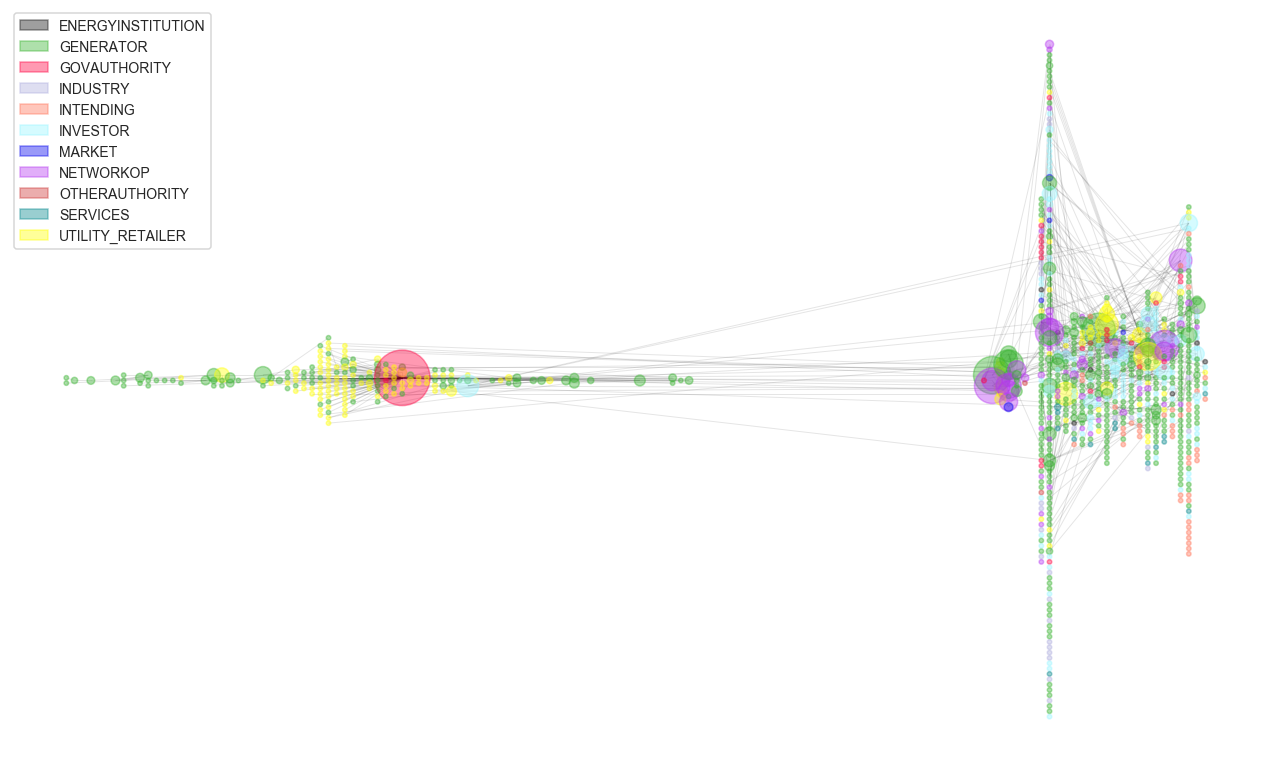

In [500]:
conn_comps = sorted(nx.connected_components(G), key=len, reverse=True)
conn_comps_greater_1 = [c for c in sorted(nx.connected_components(G), key=len, reverse=True) if len(c) > 1]

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(18, 18))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])

nodes_subgraph = {n for cc in conn_comps for n in cc}
Gcc = G.subgraph(nodes_subgraph) #conn_comps[0] the grat clique

# Betweenness centrality
bet_cen = nx.betweenness_centrality(G)
node_size_cen = [20 + v * 20000 for v in bet_cen.values()]
node_size_deg = [v * 20 for n,v in G.degree()]
node_size = [ c+d for c,d in zip(node_size_cen,node_size_deg)]
#node_size_dict = {k:v * 20000 for k,v in bet_cen.items()}


colors = [role2color(G.nodes[n]['role']) for n in G.nodes]
#pos = nx.spring_layout(Gcc, k=0.05, seed=10396953)
pos = nx.multipartite_layout(G, subset_key='start_year')

#nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20, node_color=colors,alpha=1)
nx.draw_networkx_nodes(G, pos, ax=ax0, node_size=node_size_cen, node_color=colors,alpha=0.4)
nx.draw_networkx_edges(G, pos, ax=ax0, alpha=0.1)
#ax0.set_title("Organisations in the History of Electricity Sector")
ax0.set_axis_off()

energyInst = mpatches.Patch(color=role2color('ENERGYINSTITUTION'), label='ENERGYINSTITUTION', alpha =0.4)
generator = mpatches.Patch(color=role2color('GENERATOR'), label='GENERATOR', alpha =0.4)
govAuthority = mpatches.Patch(color=role2color('GOVAUTHORITY'), label='GOVAUTHORITY', alpha =0.4)
industry = mpatches.Patch(color=role2color('INDUSTRY'), label='INDUSTRY', alpha =0.4)
intending = mpatches.Patch(color=role2color('INTENDING'), label='INTENDING', alpha =0.4)
investor = mpatches.Patch(color=role2color('INVESTOR'), label='INVESTOR', alpha =0.4)
market = mpatches.Patch(color=role2color('MARKET'), label='MARKET', alpha =0.4)
networkOp = mpatches.Patch(color=role2color('NETWORKOP'), label='NETWORKOP', alpha =0.4)
otherAuth = mpatches.Patch(color=role2color('OTHERAUTHORITY'), label='OTHERAUTHORITY', alpha =0.4)
services = mpatches.Patch(color=role2color('SERVICES'), label='SERVICES', alpha =0.4)
utilityRetailer = mpatches.Patch(color=role2color('UTILITY_RETAILER'), label='UTILITY_RETAILER', alpha =0.4)

ax0_legend = plt.legend(loc='upper left', 
                        handles=[energyInst, generator, govAuthority, industry, intending, investor, market, networkOp, otherAuth, services, utilityRetailer],
                      prop={'size': 14})


# ax1 = fig.add_subplot(axgrid[3:, :2])
# ax1.plot(degree_sequence, "b-", marker="o")
# ax1.set_title("Degree Rank Plot")
# ax1.set_ylabel("Degree")
# ax1.set_xlabel("Rank")

# ax2 = fig.add_subplot(axgrid[3:, 2:])
# ax2.bar(*np.unique(degree_sequence, return_counts=True))
# ax2.set_title("Degree histogram")
# ax2.set_xlabel("Degree")
# ax2.set_ylabel("# of Nodes")
#ax0.tick_params(bottom=True, labelbottom=True)

fig.tight_layout()
plt.show()

In [501]:
degree_dict = dict(Gcc.degree(Gcc.nodes()))

sorted_betweenness = sorted(bet_cen.items(), key=itemgetter(1), reverse=True)

print("Top 20 nodes by betweenness centrality removing nodes with degree 0:")
for b in sorted_betweenness[:20]:
    print(f"{G.nodes[b[0]]['start_year']} | {G.nodes[b[0]]['name']} | {G.nodes[b[0]]['role']} | ",
          f'betweeness: {b[1]:.3f} | Degree: {degree_dict[b[0]]}' )
    
# # Closeness centrality
# clo_cen = nx.closeness_centrality(G)
# # Eigenvector centrality
# eig_cen = nx.eigenvector_centrality(G)

Top 20 nodes by betweenness centrality removing nodes with degree 0:
1921 | State Electricity Commission Victoria (SECV) | GOVAUTHORITY |  betweeness: 0.153 | Degree: 120
1993 | Generation Victoria | GENERATOR |  betweeness: 0.069 | Degree: 6
1993 | Electricity Services Victoria | NETWORKOP |  betweeness: 0.062 | Degree: 6
2006 | AGL ENERGY LIMITED | GENERATOR |  betweeness: 0.055 | Degree: 16
2014 | AUSNET TRANSMISSION GROUP PTY LTD | NETWORKOP |  betweeness: 0.046 | Degree: 5
1995 | Southern Hydro Pty Ltd  | GENERATOR |  betweeness: 0.042 | Degree: 2
2012 | ENERGYAUSTRALIA PTY LTD | UTILITY_RETAILER |  betweeness: 0.039 | Degree: 12
2000 | SPI POWERNET PTY LTD | NETWORKOP |  betweeness: 0.038 | Degree: 3
1995 | CitiPower Pty | NETWORKOP |  betweeness: 0.031 | Degree: 7
2002 | ALINTAAGL PTY LTD | UTILITY_RETAILER |  betweeness: 0.025 | Degree: 2
2007 | ALINTA PTY LIMITED | UTILITY_RETAILER |  betweeness: 0.025 | Degree: 3
2016 | CITIPOWER PTY LTD | NETWORKOP |  betweeness: 0.025 | Deg

In [502]:
#rolesPerComponent(G)

In [503]:
# plot average degree for 'active edges and nodes' each year 
from datetime import date, timedelta
import dateutil.parser as dparser
from dateutil.relativedelta import *

def mean(data):
    n = len(data)
    mean = 0.0

    if n < 1:
        return float('nan');
    else:
        return sum(data) / n


def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

mean_degree_time = {}
graph_time = {}
edges_time = {}
nodes_time = {}
ccs_time = {}
ccs_size_time = {}
btw_time = {}
for single_date in pd.date_range(start='1/1/1880', end='1/9/2019', freq='M').values:
    sd = single_date.astype('M8[D]').astype('O')
    
    #Active nodes:
    # start_date occurs before t, i.e. sd <= t and
    # end_date occurs after t, i.e. ed >=t
    
    selected_nodes = [n for n,v in G.nodes(data=True) if dparser.parse(v['start_date'],fuzzy=True).date() <= sd and 
                      dparser.parse(v['end_date'],fuzzy=True).date() >= sd  ] 
    
    #Active Edges:
    # edge_date occurs before t, i.e. edge_date <= t and
    # src and dst end_date  + 1 month slack occurs after t, i.e. src_ed + 1month >=t and dst_ed + 1month >=t
    
    selected_edges = [ (src,dst,data) for (src,dst,data) in G.edges(data=True) 
                      if dparser.parse(data['edge_date'],fuzzy=True).date() <= sd and 
                      dparser.parse(G.nodes(data=True)[src]['end_date'],fuzzy=True).date()+relativedelta(months=+1)>= sd and
                      dparser.parse(G.nodes(data=True)[dst]['end_date'],fuzzy=True).date()+relativedelta(months=+1)>= sd
                     ]
         
    H = nx.Graph()
    H.add_nodes_from(selected_nodes)
    H.add_edges_from(selected_edges)
    
    graph_time[sd] = H
    mean_degree_time[sd] = mean([d for n, d in H.degree()])
    edges_time[sd] = len(H.edges())
    nodes_time[sd] = len(H.nodes())
    ccs_time[sd] = list(nx.connected_components(H))
    ccs_size_time[sd] = len([ cc for cc in ccs_time[sd] if len(cc)>1])
    bet_cen = nx.betweenness_centrality(H)
    sorted_betweenness = sorted(bet_cen.items(), key=itemgetter(1), reverse=True)
    btw_time[sd] = sorted_betweenness[:10]



    #print(single_date, len(selected_nodes),mean_degree_time[sd] )


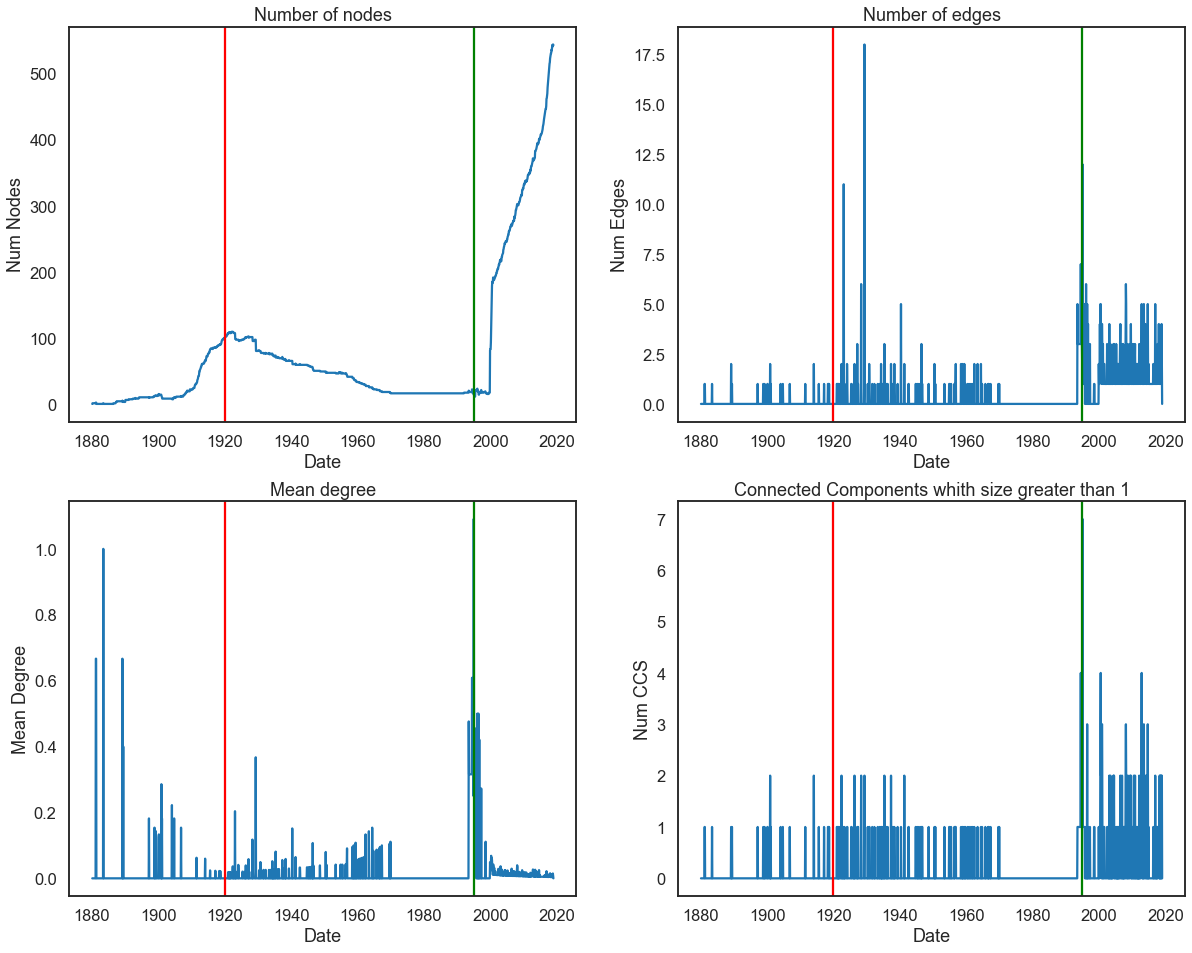

In [504]:
sns.set_context("talk")

fig = plt.figure(figsize=(20,16))
mean_degree_time_df = pd.DataFrame({'Date': list(mean_degree_time.keys()),'Mean Degree': list(mean_degree_time.values())})
mean_degree_time_df.set_index(['Date'],inplace=True)
#mean_degree_time_df.plot(figsize=(18, 18))
#plt.xticks(rotation=90)
plt.axvline(pd.Timestamp('1919-12-31'),color='r')
plt.axvline(pd.Timestamp('1994-12-31'),color='g')

plt.subplot(2,2,3)
plt.title('Mean degree')
sns.lineplot(data = mean_degree_time_df, x='Date', y = 'Mean Degree')

edges_time_df = pd.DataFrame({'Date': list(edges_time.keys()),'Num Edges': list(edges_time.values())})
edges_time_df.set_index(['Date'],inplace=True)
plt.axvline(pd.Timestamp('1919-12-31'),color='r')
plt.axvline(pd.Timestamp('1994-12-31'),color='g')

plt.subplot(222)
plt.title('Number of edges')
sns.lineplot(data = edges_time_df, x='Date', y = 'Num Edges')
plt.axvline(pd.Timestamp('1919-12-31'),color='r')
plt.axvline(pd.Timestamp('1994-12-31'),color='g')

nodes_time_df = pd.DataFrame({'Date': list(nodes_time.keys()),'Num Nodes': list(nodes_time.values())})
nodes_time_df.set_index(['Date'],inplace=True)
#nodes_time_df.plot(figsize=(18, 18))
#plt.xticks(rotation=90)

plt.subplot(221)
plt.title('Number of nodes')
sns.lineplot(data = nodes_time_df, x='Date', y = 'Num Nodes')
plt.axvline(pd.Timestamp('1919-12-31'),color='r')
plt.axvline(pd.Timestamp('1994-12-31'),color='g')

ccs_size_time_df = pd.DataFrame({'Date': list(ccs_size_time.keys()),'Num CCS': list(ccs_size_time.values())})
ccs_size_time_df.set_index(['Date'],inplace=True)
#ccs_size_time_df.plot(figsize=(18, 18))
#plt.xticks(rotation=90)

plt.subplot(2,2,4)
plt.title('Connected Components whith size greater than 1')
sns.lineplot(data = ccs_size_time_df, x='Date', y = 'Num CCS')
plt.axvline(pd.Timestamp('1919-12-31'),color='r')
plt.axvline(pd.Timestamp('1994-12-31'),color='g')

# Yearly Stats

In [505]:
# Indirect relationship if path is longer than 1. Given that the path includes always the src node, for example, 
# a path from 1 to 3 through a direct edge from 1->3 returne [1,3], then we need to check that the length of the
# len([1,3])-1 > 1 to test for indirect paths, i.e. paths longer than 1 edge

# hasIndirectRel = {}
# for src in G.nodes():
#     shortest_paths = nx.single_source_shortest_path(G,src)
#     for dst, path in shortest_paths.items():
#         if len(path)-1 > 1: 
#             hasIndirectRel[(src,dst)] = True

In [506]:
# plot average degree for 'active edges and nodes' each year 
def mean(data):
    n = len(data)
    mean = 0.0

    if n < 1:
        return float('nan');
    else:
        return sum(data) / n


def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

mean_degree_time_year = {}
graph_time_year = {}
edges_time_year = {}
nodes_time_year = {}
ccs_time_year = {}
ccs_size_time_year = {}
ccs_largest_time_year = {}
communities_time_year = {}
communities_size_time_year = {}
btw_time_year = {}
trans_size_time_year = {}
nodes_time_year_role = {}
nodes_time_year_bs = {}
nodes_time_year_region = {}
edges_time_year_rel = {}
ratioCcsNodes = {}

for single_date in pd.date_range(start='1/1/1880', end='1/9/2019', freq='Y').values:
    sd = single_date.astype('M8[D]').astype('O')
    
    #Active nodes:
    # start_date occurs before t, i.e. sd <= t and
    # end_date occurs after t, i.e. ed >=t
    
    selected_nodes = [(n,v) for n,v in G.nodes(data=True) if dparser.parse(v['start_date'],fuzzy=True).date() <= sd 
                       and dparser.parse(v['end_date'],fuzzy=True).date() +relativedelta(years=+1) >= sd  
                     ] 
    
    #Active Edges:
    # edge_date occurs before t, i.e. edge_date <= t and
    # src and dst end_date  + 1 month slack occurs after t, i.e. src_ed + 1month >=t and dst_ed + 1month >=t
    
    selected_edges = [ (src,dst,data) for (src,dst,data) in G.edges(data=True) 
                      if dparser.parse(data['edge_date'],fuzzy=True).date() <= sd 
                       and dparser.parse(G.nodes(data=True)[src]['end_date'],fuzzy=True).date()+relativedelta(years=+1)>= sd and
                       dparser.parse(G.nodes(data=True)[dst]['end_date'],fuzzy=True).date()+relativedelta(years=+1)>= sd
                     ]
    
#     # Add indirect edges to nodes that are still active. Rel type 9 means indirect, the edge date is
#     # the current date of the snapshot
#     for (src,v) in selected_nodes:
#         for (dst,v) in selected_nodes:
#             if (src,dst) in hasIndirectRel.keys():
#                 edge = ( src, dst, {'relationship': 9, 'edge_date': sd.strftime("%Y-%m-%d")})
#                 selected_edges.append(edge)

    H = nx.Graph()
    H.add_nodes_from(selected_nodes)
    H.add_edges_from(selected_edges)
    
    graph_time_year[sd] = H
    mean_degree_time_year[sd] = mean([d for n, d in H.degree()])
    edges_time_year[sd] = len(H.edges())
    nodes_time_year[sd] = len(H.nodes())
    
    for role in roles:
        nodes_time_year_role[(sd,role)] = len([ r for r in H.nodes() if G.nodes[r]['role'] == role])
    
    for bs in business_structures:
        nodes_time_year_bs[(sd,bs)] = len([ r for r in H.nodes() if G.nodes[r]['business'] == bs])
        
    for reg in regions:
        nodes_time_year_region[(sd,reg)] = len([ r for r in H.nodes() if G.nodes[r]['region'] == reg])
     
    for rel in relationships:
        edges_time_year_rel[(sd,rel)] = len([ (src,dst,data) for src,dst,data in H.edges(data=True) if data['relationship'] == rel])
        
    ccs_time_year[sd] = list(nx.connected_components(H))
    ccs_size_time_year[sd] = len([ cc for cc in ccs_time_year[sd] if len(cc)>1])
    ccs_largest_time_year[sd] = len(max(ccs_time_year[sd], key=len))
    if len(H.edges()) > 0:
        communities_time_year[sd] = list(community.greedy_modularity_communities(H))
        communities_size_time_year[sd] = len([ cc for cc in communities_time_year[sd] if len(cc)>1])
    else:
        communities_time_year[sd] = 0
        communities_size_time_year[sd] = 0
        
    trans_size_time_year[sd] = nx.transitivity(H)
    bet_cen = nx.betweenness_centrality(H)
    sorted_betweenness = sorted(bet_cen.items(), key=itemgetter(1), reverse=True)
    btw_time_year[sd] = sorted_betweenness[:10]
    ratioCcsNodes[sd] = (ccs_largest_time_year[sd]/nodes_time_year[sd])*100


    #print(single_date, len(selected_nodes),mean_degree_time[sd] )

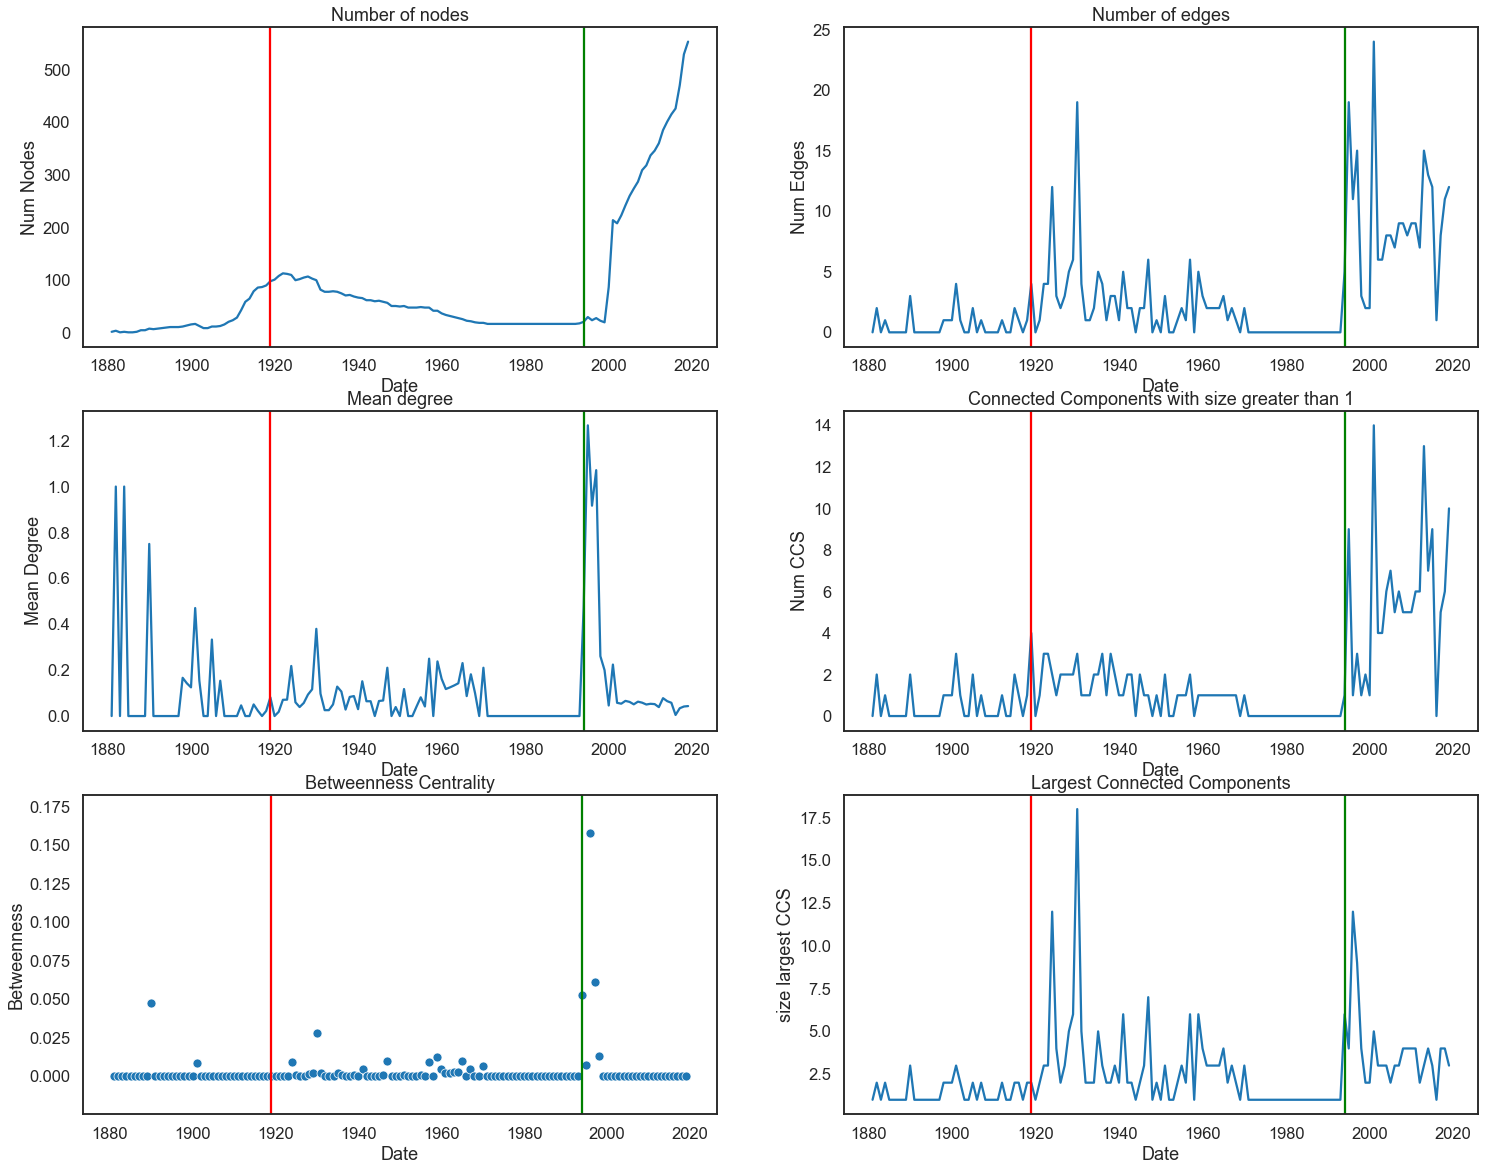

In [508]:
sns.set_context("talk")
fig = plt.figure(figsize=(25,20))
#fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6, sharex=True)

nodes_time_year_df = pd.DataFrame({'Date': list(nodes_time_year.keys()),'Num Nodes': list(nodes_time_year.values())})
nodes_time_year_df.set_index(['Date'],inplace=True)

edges_time_year_df = pd.DataFrame({'Date': list(edges_time_year.keys()),'Num Edges': list(edges_time_year.values())})
edges_time_year_df.set_index(['Date'],inplace=True)

mean_degree_time_year_df = pd.DataFrame({'Date': list(mean_degree_time_year.keys()),'Mean Degree': list(mean_degree_time_year.values())})
mean_degree_time_year_df.set_index(['Date'],inplace=True)

ccs_size_time_year_df = pd.DataFrame({'Date': list(ccs_size_time_year.keys()),'Num CCS': list(ccs_size_time_year.values())})
ccs_size_time_year_df.set_index(['Date'],inplace=True)

communities_size_time_year_df = pd.DataFrame({'Date': list(communities_size_time_year.keys()),'Num Communities': list(communities_size_time_year.values())})
communities_size_time_year_df.set_index(['Date'],inplace=True)

ccs_largest_time_year_df = pd.DataFrame({'Date': list(ccs_largest_time_year.keys()),'size largest CCS': list(ccs_largest_time_year.values())})
ccs_largest_time_year_df.set_index(['Date'],inplace=True)

trans_size_time_year_df = pd.DataFrame({'Date': list(trans_size_time_year.keys()),'Transitivity': list(trans_size_time_year.values())})
trans_size_time_year_df.set_index(['Date'],inplace=True)

# btw_time_year_df = pd.DataFrame({'Date': list(btw_time_year.keys()),'Betweenness Centrality': list(btw_time_year.values())})
# btw_time_year_df.set_index(['Date'],inplace=True)

btw_time_df = pd.DataFrame({'Date': list(btw_time_year.keys()),'Betweenness': [ max(v, key=itemgetter(1))[1] for v in btw_time_year.values()]})
btw_time_df.set_index(['Date'],inplace=True)


#mean_degree_time_df.plot(figsize=(18, 18))
#plt.xticks(rotation=90)
r1EndLine = '1919-1-1'
r2EndLine = '1994-1-1'
plt.axvline(pd.Timestamp(r1EndLine),color='r')
plt.axvline(pd.Timestamp(r2EndLine),color='g')

#number of nodes

ax1 = plt.subplot(321)
plt.title('Number of nodes')
sns.lineplot(data = nodes_time_year_df, x='Date', y = 'Num Nodes')
plt.axvline(pd.Timestamp(r1EndLine),color='r')
plt.axvline(pd.Timestamp(r2EndLine),color='g')

# number of edges

ax2 = plt.subplot(322)
plt.title('Number of edges')
sns.lineplot(data = edges_time_year_df, x='Date', y = 'Num Edges')
plt.axvline(pd.Timestamp(r1EndLine),color='r')
plt.axvline(pd.Timestamp(r2EndLine),color='g')

#nodes_time_df.plot(figsize=(18, 18))
#plt.xticks(rotation=90)

# mean degree

ax3 = plt.subplot(3,2,3, sharex=ax1)
plt.title('Mean degree')
sns.lineplot(data = mean_degree_time_year_df, x='Date', y = 'Mean Degree')
plt.axvline(pd.Timestamp(r1EndLine),color='r')
plt.axvline(pd.Timestamp(r2EndLine),color='g')

# connected components

ax4 = plt.subplot(3,2,4, sharex=ax2)
plt.title('Connected Components with size greater than 1')
sns.lineplot(data = ccs_size_time_year_df, x='Date', y = 'Num CCS')
plt.axvline(pd.Timestamp(r1EndLine),color='r')
plt.axvline(pd.Timestamp(r2EndLine),color='g')


ax5 = plt.subplot(3,2,5)
plt.title('Betweenness Centrality')
plt.axvline(pd.Timestamp(r1EndLine),color='r')
plt.axvline(pd.Timestamp(r2EndLine),color='g')
# max_btw = [] 
# for vs in btw_time_year_ccs.values():
#     max_v = 0
#     for _,v in vs:
#         if v > max_v: max_v = v
#     max_btw.append(max_v)
    
#btw_time_df = pd.DataFrame({'Date': list(btw_time_year.keys()),'Max Betweeness': max_btw})
#btw_time_df.set_index(['Date'],inplace=True)
sns.scatterplot(data = btw_time_df, x='Date', y = 'Betweenness')

#transitivity measure over time
ax6 = plt.subplot(3,2,6)
plt.title('Largest Connected Components')
sns.lineplot(data = ccs_largest_time_year_df, x='Date', y = 'size largest CCS')
plt.axvline(pd.Timestamp(r1EndLine),color='r')
plt.axvline(pd.Timestamp(r2EndLine),color='g')


[Text(0, 0, '1880'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '1884'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '1888'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '1892'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '1896'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '1900'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '1904'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '1908'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '1912'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '1916'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '1920'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '1924'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '1928'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '1932'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 

<Figure size 864x864 with 0 Axes>

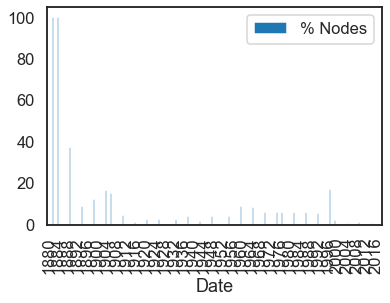

In [509]:
fig = plt.figure(figsize=(12,12))
perNodesLcc_year_df = pd.DataFrame({'Date': list([ d.year for d in ratioCcsNodes.keys() ]),'% Nodes': list(ratioCcsNodes.values())})
perNodesLcc_year_df.set_index(['Date'],inplace=True)


ax = perNodesLcc_year_df.plot.bar()

ax.set_xticklabels([ x if int(x.get_text()) % 4 == 0 else '' for x in ax.get_xticklabels()])


In [510]:
bet_cen = nx.betweenness_centrality(G)

sorted_betweenness = sorted(bet_cen.items(), key=itemgetter(1), reverse=True)

for b in sorted_betweenness[:10]:
    print(f"{G.nodes[b[0]]['start_year']} | {G.nodes[b[0]]['name']} | {G.nodes[b[0]]['role']} | ",
          f'betweeness: {b[1]:.3f} | Degree: {degree_dict[b[0]]}' )

1921 | State Electricity Commission Victoria (SECV) | GOVAUTHORITY |  betweeness: 0.153 | Degree: 120
1993 | Generation Victoria | GENERATOR |  betweeness: 0.069 | Degree: 6
1993 | Electricity Services Victoria | NETWORKOP |  betweeness: 0.062 | Degree: 6
2006 | AGL ENERGY LIMITED | GENERATOR |  betweeness: 0.055 | Degree: 16
2014 | AUSNET TRANSMISSION GROUP PTY LTD | NETWORKOP |  betweeness: 0.046 | Degree: 5
1995 | Southern Hydro Pty Ltd  | GENERATOR |  betweeness: 0.042 | Degree: 2
2012 | ENERGYAUSTRALIA PTY LTD | UTILITY_RETAILER |  betweeness: 0.039 | Degree: 12
2000 | SPI POWERNET PTY LTD | NETWORKOP |  betweeness: 0.038 | Degree: 3
1995 | CitiPower Pty | NETWORKOP |  betweeness: 0.031 | Degree: 7
2002 | ALINTAAGL PTY LTD | UTILITY_RETAILER |  betweeness: 0.025 | Degree: 2


In [511]:
print("Top 20 nodes by betweenness centrality:")
for d,btw in btw_time_year.items():
    print(d)
    for b in btw[:1]:
        org = organisations_data[ organisations_data.index == b[0] ]
        print('\t',org[['Organisation Name','Role']].values, f'betweeness: {b[1]:.9f}' )


Top 20 nodes by betweenness centrality:
1880-12-31
	 [['Victorian Electric Light Co.' 'GENERATOR']] betweeness: 0.000000000
1881-12-31
	 [['Victorian Electric Light Co.' 'GENERATOR']] betweeness: 0.000000000
1882-12-31
	 [['Australian Electric Light Co Ltd.' 'GENERATOR']] betweeness: 0.000000000
1883-12-31
	 [['Australian Electric Light Co Ltd.' 'GENERATOR']] betweeness: 0.000000000
1884-12-31
	 [['(New) Australasian Electric Co. Ltd.' 'GENERATOR']] betweeness: 0.000000000
1885-12-31
	 [['(New) Australasian Electric Co. Ltd.' 'GENERATOR']] betweeness: 0.000000000
1886-12-31
	 [['(New) Australasian Electric Co. Ltd.' 'GENERATOR']] betweeness: 0.000000000
1887-12-31
	 [['(New) Australasian Electric Co. Ltd.' 'GENERATOR']] betweeness: 0.000000000
1888-12-31
	 [['(New) Australasian Electric Co. Ltd.' 'GENERATOR']] betweeness: 0.000000000
1889-12-31
	 [['Union Electric Co. of Australia Ltd.' 'GENERATOR']] betweeness: 0.047619048
1890-12-31
	 [['New Australian Electric Co. Ltd.' 'GENERATOR']

## Communities

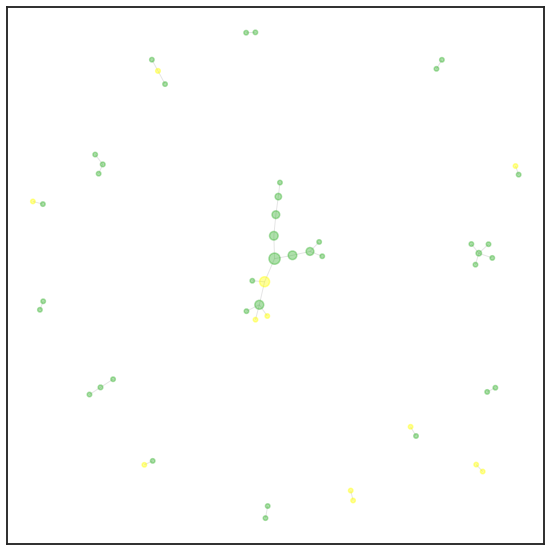

In [628]:
sns.set_style("white")

def set_node_community(G, communities):
        '''Add community to node attributes'''
        for c, v_c in enumerate(communities):
            for v in v_c:
                # Add 1 to save 0 for external edges
                G.nodes[v]['community'] = c + 1

def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0

def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)   

# communities during regimes,: emerging: 1879, 1, 1 to 1919, 12, 31; public: 1920, 1, 1 to 1994, 12, 31; private until 2019
graph_date_start = date(1879, 1, 1)
graph_date_end = date(1919, 12, 31)

   
selected_nodes = [(n,v) for n,v in G.nodes(data=True) if 
                  dparser.parse(v['start_date'],fuzzy=True).date() >= graph_date_start and
                  dparser.parse(v['start_date'],fuzzy=True).date() <= graph_date_end] 
    
#Active Edges:
# edge_date occurs before t, i.e. edge_date <= t and
# src and dst end_date  + 1 month slack occurs after t, i.e. src_ed + 1month >=t and dst_ed + 1month >=t

selected_edges = [ (src,dst,data) for (src,dst,data) in G.edges(data=True) 
                  if 
                  dparser.parse(G.nodes(data=True)[src]['end_date'],fuzzy=True).date() >= graph_date_start and
                  dparser.parse(G.nodes(data=True)[dst]['start_date'],fuzzy=True).date() >= graph_date_start and
                  dparser.parse(G.nodes(data=True)[src]['start_date'],fuzzy=True).date() <= graph_date_end and
                  dparser.parse(G.nodes(data=True)[dst]['start_date'],fuzzy=True).date() <= graph_date_end
                 ]

#Create graph with nodes and edges before Regime
Gt = nx.Graph()
Gt.add_nodes_from(selected_nodes)
Gt.add_edges_from(selected_edges)

#Recognize communities
communities = sorted(community.greedy_modularity_communities(Gt), key=len, reverse=True)

x=1
big_communities = []
for i,c in enumerate(communities): # Loop through the list of communities
    if len(c) > x : # Filter out modularity classes with x or fewer nodes
        #print('Class '+str(i)+':', list(c)) # Print out the classes and their members
        communities = i 
        big_communities.append(c)

#Select nodes bigger than x. See above
nodes_subgraph = {n for c in big_communities for n in c}

selected_communities_nodes = [ (n,data)  for n,data in G.nodes(data=True) if n in nodes_subgraph] 

selected_communities_edges = [ (src,dst,data) for (src,dst,data) in G.edges(data=True) 
                  if src in nodes_subgraph and dst in nodes_subgraph]

Gcomreg = nx.Graph()
Gcomreg.add_nodes_from(selected_communities_nodes)
Gcomreg.add_edges_from(selected_communities_edges)

# Gcomreg = Gt.subgraph(nodes_subgraph)
# set_node_community(Gcomreg, big_communities)
# set_edge_community(big_communities)
#Gcomreg.add_nodes_from(selected_nodes)
#Gcomreg.add_edges_from(selected_edges)

# Betweenness centrality
bet_cen = nx.betweenness_centrality(Gcomreg)
node_size_cen = [20 + v * 2000 for v in bet_cen.values()]
node_size_deg = [v * 20 for n,v in Gcomreg.degree()]
node_size = [ c+d for c,d in zip(node_size_cen,node_size_deg)]
#node_size_dict = {k:v * 20000 for k,v in bet_cen.items()}


colors = [role2color(Gcomreg.nodes[n]['role']) for n in Gcomreg.nodes]
pos = nx.spring_layout(Gcomreg, k=0.1) #10396953
#pos = nx.multipartite_layout(Gcomreg, subset_key='rolenum')
#pos = nx.spiral_layout(Gcomreg)

fig = plt.figure(figsize=(8,8))
#nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20, node_color=colors,alpha=1)
nx.draw_networkx_nodes(Gcomreg, pos, node_size=node_size_cen, node_color=colors,alpha=0.4)
nx.draw_networkx_edges(Gcomreg, pos, alpha=0.1)
#ax0.set_title("Organisations in the History of Electricity Sector")
#ax0.set_axis_off()
transp = 0.4
energyInst = mpatches.Patch(color=role2color('ENERGYINSTITUTION'), label='ENERGYINSTITUTION', alpha =transp)
generator = mpatches.Patch(color=role2color('GENERATOR'), label='GENERATOR', alpha =transp)
govAuthority = mpatches.Patch(color=role2color('GOVAUTHORITY'), label='GOVAUTHORITY', alpha =transp)
industry = mpatches.Patch(color=role2color('INDUSTRY'), label='INDUSTRY', alpha =transp)
intending = mpatches.Patch(color=role2color('INTENDING'), label='INTENDING', alpha =transp)
investor = mpatches.Patch(color=role2color('INVESTOR'), label='INVESTOR', alpha =transp)
market = mpatches.Patch(color=role2color('MARKET'), label='MARKET', alpha =transp)
networkOp = mpatches.Patch(color=role2color('NETWORKOP'), label='NETWORKOP', alpha =transp)
otherAuth = mpatches.Patch(color=role2color('OTHERAUTHORITY'), label='OTHERAUTHORITY', alpha =transp)
services = mpatches.Patch(color=role2color('SERVICES'), label='SERVICES', alpha =transp)
utilityRetailer = mpatches.Patch(color=role2color('UTILITY_RETAILER'), label='UTILITY_RETAILER', alpha =transp)

#plt.legend(handles=[energyInst, generator, govAuthority, industry, intending, investor, market, networkOp, otherAuth, services, utilityRetailer],
 #        prop={'size': 18}, loc='upper left', ncol = 6, mode="expand")


fig.tight_layout()
plt.show()

In [610]:
# modularity_dict = {} # Create a blank dictionary
# for i,c in enumerate(communities): # Loop through the list of communities, keeping track of the number for the community
#     for name in c: # Loop through each person in a community
#         modularity_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

# # Now you can add modularity information like we did the other metrics
# nx.set_node_attributes(Gcomreg, modularity_dict, 'modularity')

# community_0 = sorted(communities[0])
# community_1 = sorted(communities[1])
# community_2 = sorted(communities[2])

# print(len(communities))

In [426]:
# eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality
# nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')


# # First get a list of just the nodes in that class
# class0 = [n for n in G.nodes() if G.nodes[n]['modularity'] == 0]

# # Then create a dictionary of the eigenvector centralities of those nodes
# class0_eigenvector = {n:G.nodes[n]['eigenvector'] for n in class0}

# # Then sort that dictionary and print the first 5 results
# class0_sorted_by_eigenvector = sorted(class0_eigenvector.items(), key=itemgetter(1), reverse=True)

# print("Modularity Class 0 Sorted by Eigenvector Centrality:")
# for node in class0_sorted_by_eigenvector[:5]:
#     print("Name:", node[0], "| Eigenvector Centrality:", node[1])

## Roles

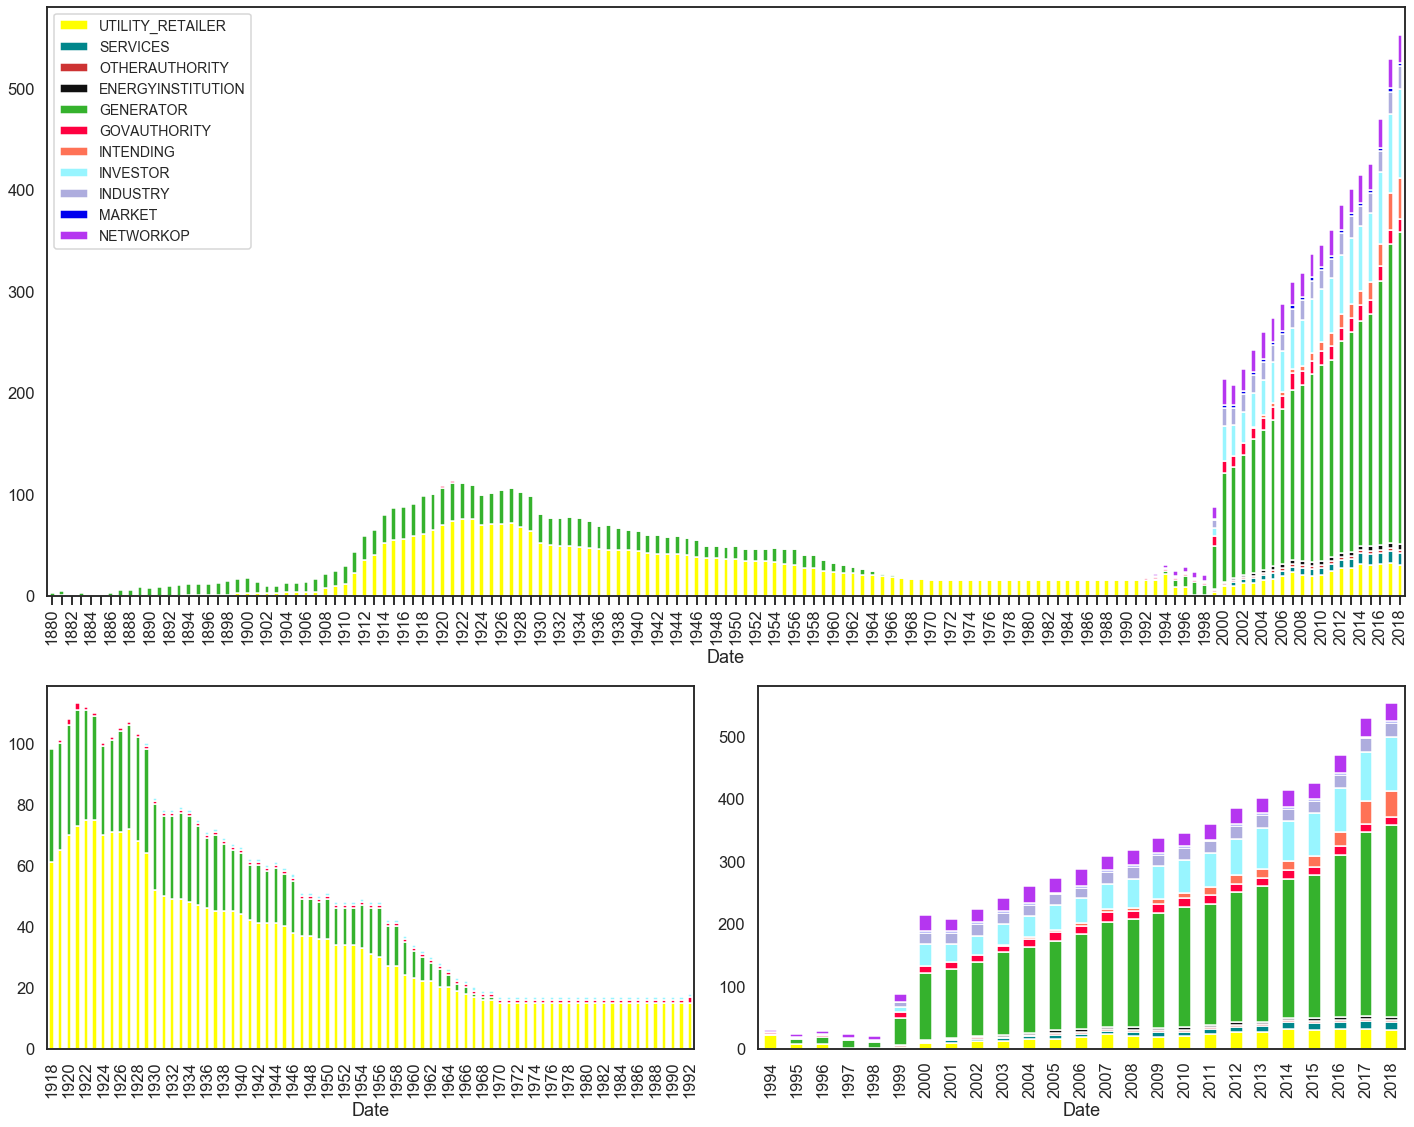

In [519]:
fig = plt.figure("Organisation Roles over time", figsize=(18, 18))

# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)


# Add figure with all years
ax0 = fig.add_subplot(axgrid[0:3, :])

dataset = {'Date': [ d.year for d in nodes_time_year.keys() ]}
colors = []
for role in roles:
    dataset[role]= [ v for (d,r),v in nodes_time_year_role.items() if r == role]
    colors.append(role2color(role))
   

nodes_time_year_role_df = pd.DataFrame(dataset)
nodes_time_year_role_df = nodes_time_year_role_df.set_index('Date')

nodes_time_year_role_df.plot.bar(ax=ax0,stacked=True, figsize=(20,16), color=colors)

ax0.grid(False)

ax0.tick_params(bottom=True, labelbottom=True)
ax0.set_xticklabels([ x if int(x.get_text()) % 2 == 0 else '' for x in ax0.get_xticklabels()])

ax0.axvline(x=pd.Timestamp(r1EndLine),color='r')
ax0.axvline(x=pd.Timestamp(r2EndLine),color='g')
ax0 = plt.legend(prop={'size': 14})

# Add figure from 1918 to 1969

ax1 = fig.add_subplot(axgrid[3:, :2])


dataset = {'Date': [ d.year for d in nodes_time_year.keys() if d.year >= 1918 and d.year < 1993]}
colors = []
for role in roles:
    dataset[role]= [ v for (d,r),v in nodes_time_year_role.items() if r == role and d.year >= 1918 and d.year < 1993]
    colors.append(role2color(role))
   

nodes_time_year_role_df = pd.DataFrame(dataset)
nodes_time_year_role_df = nodes_time_year_role_df.set_index('Date')

nodes_time_year_role_df.plot.bar(ax=ax1,stacked=True, figsize=(20,16), color=colors)
ax1.set_xticklabels([ x if int(x.get_text()) % 2 == 0 else '' for x in ax1.get_xticklabels()])

# Add figure from 1994 onwards

ax2 = fig.add_subplot(axgrid[3:, 2:])


dataset = {'Date': [ d.year for d in nodes_time_year.keys() if d.year >= 1994]}
colors = []
for role in roles:
    dataset[role]= [ v for (d,r),v in nodes_time_year_role.items() if r == role and d.year >= 1994]
    colors.append(role2color(role))
   

nodes_time_year_role_df = pd.DataFrame(dataset)
nodes_time_year_role_df = nodes_time_year_role_df.set_index('Date')

nodes_time_year_role_df.plot.bar(ax=ax2,stacked=True, figsize=(20,16), color=colors)

ax2.get_legend().remove()
ax1.get_legend().remove()
fig.tight_layout()
plt.show()


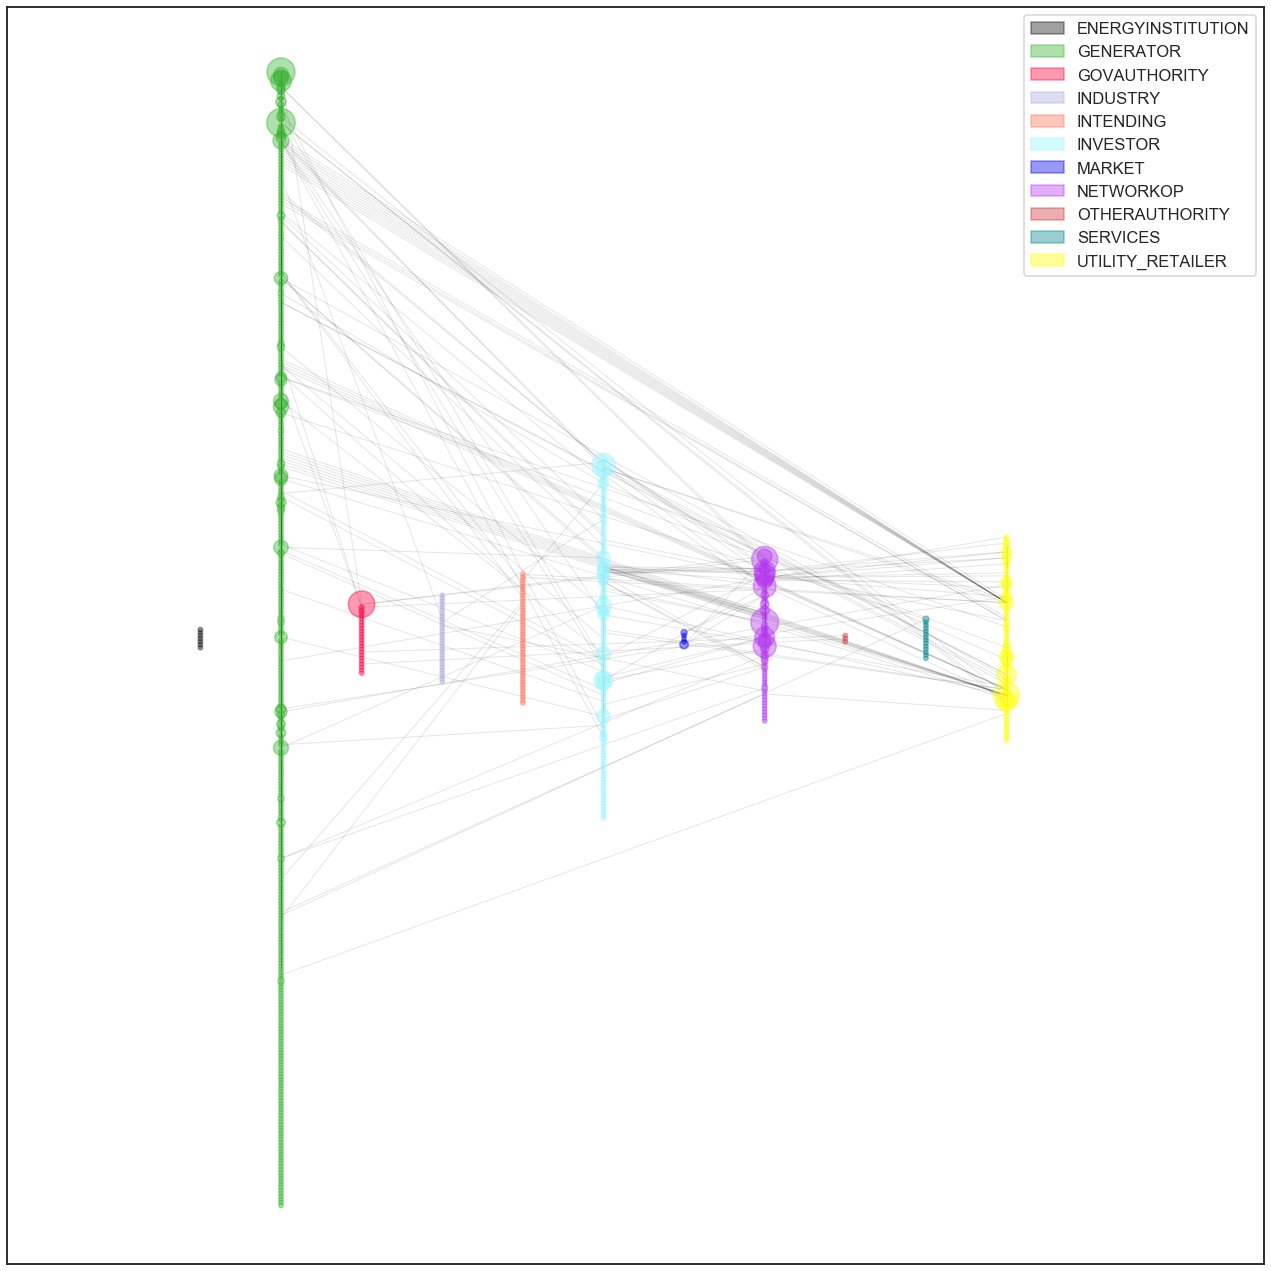

In [551]:
graph_date = date(1995, 1, 1)

selected_nodes = [(n,v) for n,v in G.nodes(data=True) if 
                  dparser.parse(v['end_date'],fuzzy=True).date()+relativedelta(years=+1) >= graph_date] 
    
#Active Edges:
# edge_date occurs before t, i.e. edge_date <= t and
# src and dst end_date  + 1 month slack occurs after t, i.e. src_ed + 1month >=t and dst_ed + 1month >=t

selected_edges = [ (src,dst,data) for (src,dst,data) in G.edges(data=True) 
                  if 
                  dparser.parse(G.nodes(data=True)[src]['end_date'],fuzzy=True).date()+relativedelta(years=+1)>= graph_date and
                  dparser.parse(G.nodes(data=True)[dst]['end_date'],fuzzy=True).date()+relativedelta(years=+1)>= graph_date
                 ]

Gt = nx.Graph()
Gt.add_nodes_from(selected_nodes)
Gt.add_edges_from(selected_edges)
    
#Gt = graph_time_year[graph_date]
#Gt = G

fig = plt.figure(figsize=(18, 18))
conn_comps = sorted(nx.connected_components(Gt), key=len, reverse=True)
nodes_subgraph = {n for cc in conn_comps if len(cc) > 1 for n in cc}
#Gt = G.subgraph(nodes_subgraph) #conn_comps[0] the grat clique

# Betweenness centrality
bet_cen = nx.betweenness_centrality(Gt)
node_size_cen = [20 + v * 20000 for v in bet_cen.values()]
node_size_deg = [v * 20 for n,v in Gt.degree()]
node_size = [ c+d for c,d in zip(node_size_cen,node_size_deg)]
#node_size_dict = {k:v * 20000 for k,v in bet_cen.items()}


colors = [role2color(Gt.nodes[n]['role']) for n in Gt.nodes]
#pos = nx.spring_layout(Gcc, k=0.05, seed=10396953)
pos = nx.multipartite_layout(Gt, subset_key='rolenum')
#pos = nx.circular_layout(Gt)

#nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20, node_color=colors,alpha=1)
nx.draw_networkx_nodes(Gt, pos, node_size=node_size_cen, node_color=colors,alpha=0.4)
nx.draw_networkx_edges(Gt, pos, alpha=0.1)
#ax0.set_title("Organisations in the History of Electricity Sector")
#ax0.set_axis_off()
transp = 0.4
energyInst = mpatches.Patch(color=role2color('ENERGYINSTITUTION'), label='ENERGYINSTITUTION', alpha =transp)
generator = mpatches.Patch(color=role2color('GENERATOR'), label='GENERATOR', alpha =transp)
govAuthority = mpatches.Patch(color=role2color('GOVAUTHORITY'), label='GOVAUTHORITY', alpha =transp)
industry = mpatches.Patch(color=role2color('INDUSTRY'), label='INDUSTRY', alpha =transp)
intending = mpatches.Patch(color=role2color('INTENDING'), label='INTENDING', alpha =transp)
investor = mpatches.Patch(color=role2color('INVESTOR'), label='INVESTOR', alpha =transp)
market = mpatches.Patch(color=role2color('MARKET'), label='MARKET', alpha =transp)
networkOp = mpatches.Patch(color=role2color('NETWORKOP'), label='NETWORKOP', alpha =transp)
otherAuth = mpatches.Patch(color=role2color('OTHERAUTHORITY'), label='OTHERAUTHORITY', alpha =transp)
services = mpatches.Patch(color=role2color('SERVICES'), label='SERVICES', alpha =transp)
utilityRetailer = mpatches.Patch(color=role2color('UTILITY_RETAILER'), label='UTILITY_RETAILER', alpha =transp)

plt.legend(handles=[energyInst, generator, govAuthority, industry, intending, investor, market, networkOp, otherAuth, services, utilityRetailer])

fig.tight_layout()
plt.show()

### Shortest paths

In [552]:
ssp = [ Gt.nodes[node_id] for node_id in nx.shortest_path(Gt, source=213, target=203)]
ssp

[{'name': 'Hazelwood Power (partnership)',
  'start_year': 1996,
  'start_date': '1996-08-01',
  'end_date': '2003-01-01',
  'region': 'VIC',
  'role': 'GENERATOR',
  'rolenum': 1,
  'business': 'Australian Private Company'},
 {'name': 'Hazelwood Power Co. Pty Ltd',
  'start_year': 1995,
  'start_date': '1995-06-18',
  'end_date': '1996-08-01',
  'region': 'VIC',
  'role': 'GENERATOR',
  'rolenum': 1,
  'business': 'Australian Private Company'}]

#### Cluster example

19043


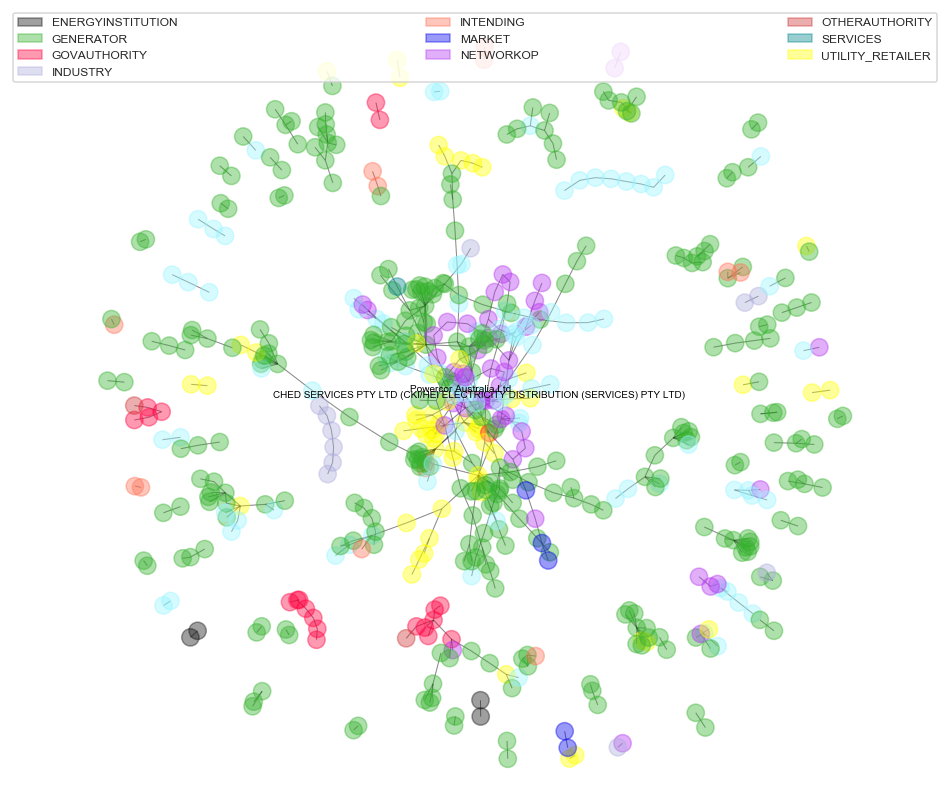

In [553]:
fig = plt.figure(figsize=(13, 11))

conn_comps = sorted(nx.connected_components(Gt), key=len, reverse=True)
nodes_subgraph = {n for cc in conn_comps if len(cc) > 1 for n in cc}

Gs = Gt.subgraph(nodes_subgraph)
colors = [role2color(Gs.nodes[n]['role']) for n in Gs.nodes]

seed = int(random.random()*100000)
print(seed)

pos = nx.spring_layout(Gs, k=0.05, seed=seed)
#pos = nx.nx.multipartite_layout(Gs, subset_key='rolenum')
#pos = nx.kamada_kawai_layout(Gs, scale=0.1)

#pos = nx.fruchterman_reingold_layout(Gs, k=0.01, seed=99503)
#10396967, 83581, 5895, k=0.01, seed=99503
nx.draw(Gs,pos,node_color=colors, alpha=0.4)
# draw path
path = nx.shortest_path(Gs,source=209, target=931)
path_edges = zip(path,path[1:])
path_edges = set(path_edges)

labels = {}
for o in Gs.nodes():
    if o in path:
        labels[o] = Gs.nodes[o]['name']
        
nx.draw_networkx_labels(Gs,pos,labels,font_size=10,font_color='black')
#nx.draw_networkx_nodes(Gs, pos, node_size=node_size_cen, node_color=colors,alpha=0.6)
nx.draw_networkx_edges(Gs, pos, alpha=0.1)

#nx.draw_networkx_nodes(Gs, pos, nodelist=path, node_color='r',alpha=0.4)
nx.draw_networkx_edges(Gs, pos, edgelist=path_edges, edge_color='r',width=5, alpha=0.5)
#pos = nx.multipartite_layout(Gs, subset_key='rolenum')
plt.legend(handles=[energyInst, generator, govAuthority, industry, intending, market, networkOp, otherAuth, services, utilityRetailer], 
           loc='upper right', prop={'size': 12},ncol = 3, mode="expand")

plt.axis('equal')
#43179
#fig.tight_layout()
plt.show()

In [554]:
# print(f"\t Src: {src} - {organisations_data.loc[src]['Organisation Name']} - {relnum2relname(rel)} " \
#                         f"{organisations_data.loc[dst]['Date of Change']}"

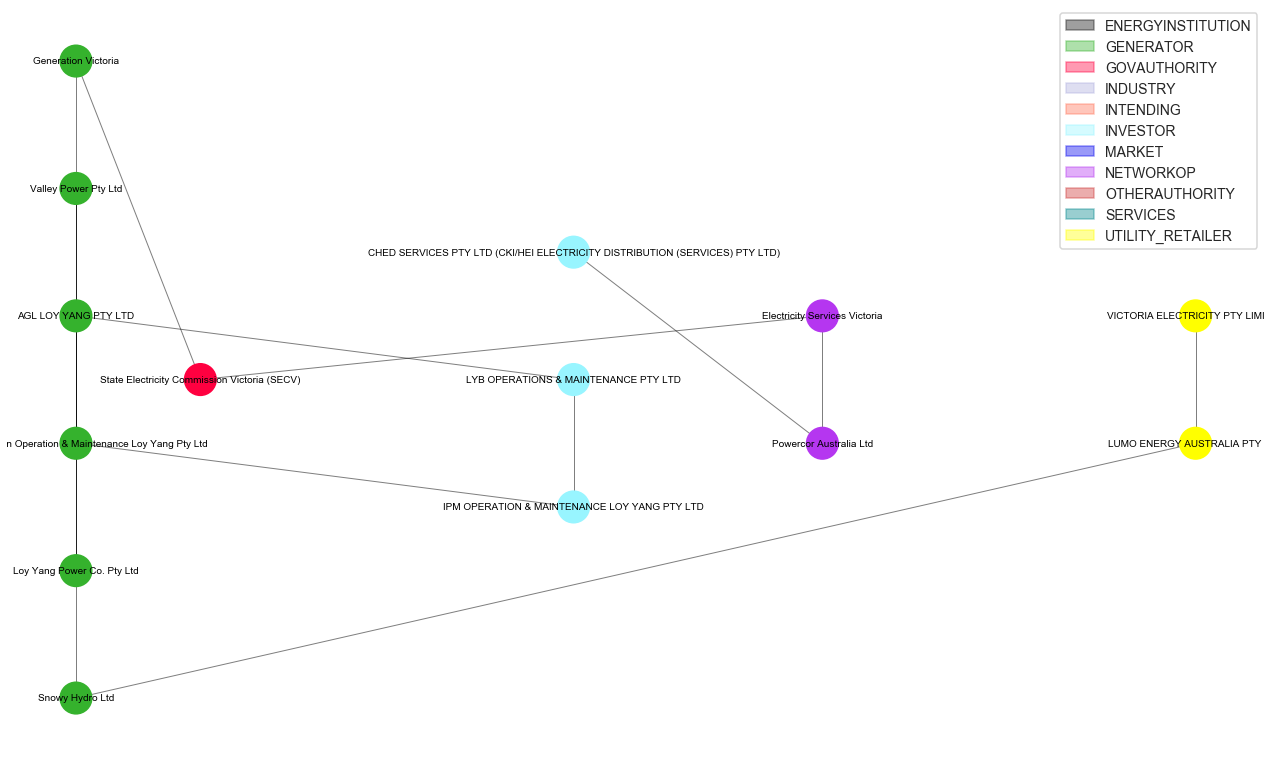

In [555]:
ssp_nodes = nx.shortest_path(Gt, source=931, target=247)
 
fig = plt.figure("SSP", figsize=(18, 18))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])

Gcc = G.subgraph(ssp_nodes) #conn_comps[0] the grat clique

colors = [role2color(G.nodes[n]['role']) for n in Gcc.nodes]

#pos = nx.spring_layout(Gcc, k=0.05, seed=10396953)
pos = nx.multipartite_layout(Gcc, subset_key='rolenum')
#pos = nx.bipartite_layout(Gcc,ssp_nodes)
#pos = nx.planar_layout(Gcc)

labels = {}
for n in Gcc.nodes():
    labels[n] = G.nodes[n]['name']
        

nx.draw_networkx_labels(Gcc,pos,labels,font_size=10,font_color='black')
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=1000, node_color=colors,alpha=1)
# nx.draw_networkx_nodes(G, pos, ax=ax0, node_size=node_size_cen, node_color=colors,alpha=0.4)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.5)
#ax0.set_title("Organisations in the History of Electricity Sector")
ax0.set_axis_off()

energyInst = mpatches.Patch(color=role2color('ENERGYINSTITUTION'), label='ENERGYINSTITUTION', alpha =0.4)
generator = mpatches.Patch(color=role2color('GENERATOR'), label='GENERATOR', alpha =0.4)
govAuthority = mpatches.Patch(color=role2color('GOVAUTHORITY'), label='GOVAUTHORITY', alpha =0.4)
industry = mpatches.Patch(color=role2color('INDUSTRY'), label='INDUSTRY', alpha =0.4)
intending = mpatches.Patch(color=role2color('INTENDING'), label='INTENDING', alpha =0.4)
investor = mpatches.Patch(color=role2color('INVESTOR'), label='INVESTOR', alpha =0.4)
market = mpatches.Patch(color=role2color('MARKET'), label='MARKET', alpha =0.4)
networkOp = mpatches.Patch(color=role2color('NETWORKOP'), label='NETWORKOP', alpha =0.4)
otherAuth = mpatches.Patch(color=role2color('OTHERAUTHORITY'), label='OTHERAUTHORITY', alpha =0.4)
services = mpatches.Patch(color=role2color('SERVICES'), label='SERVICES', alpha =0.4)
utilityRetailer = mpatches.Patch(color=role2color('UTILITY_RETAILER'), label='UTILITY_RETAILER', alpha =0.4)

ax0_legend = plt.legend(loc='upper right', 
                        handles=[energyInst, generator, govAuthority, industry, intending, investor, market, networkOp, otherAuth, services, utilityRetailer],
                        prop={'size': 14})

fig.tight_layout()
plt.show()


{'UTILITY_RETAILER', 'SERVICES', 'GENERATOR', 'GOVAUTHORITY', 'INTENDING', 'INVESTOR', 'INDUSTRY', 'MARKET', 'NETWORKOP'}
254
	 512 PACIFIC HYDRO INTERNATIONAL PTY. LTD.
	 513 Singapore Power International Pte Ltd.
	 514 SP Group Pty Ltd
	 517 LYP PARTNER 3 PTY LTD	
	 510 Pacific Hydro Investments Pty Ltd
	 519 TANGO ENERGY PTY LTD
	 520 SPI (Australia) Assets Pty Ltd
	 714 HEI Utilities Development Limited
	 521 SGSP (AUSTRALIA) ASSETS PTY LTD
	 522 JEMENA ENERGY ASSETS PTY. LTD.
	 524 AGL Loy Yang Marketing  Pty Ltd
	 523 OVIDA INFRASTRUCTURE PTY LTD
	 518 Pacific Hydro Retail Pty Ltd
	 527 Enel X Australia Pty Ltd
	 716 Woodlawn Bioreactor Energy Pty Ltd
	 531 NovaPower Pty Ltd
	 534 Pacific Hydro Yaloak South Pty Ltd
	 543 AGL Sales (Queensland Electricity) Pty Ltd
	 544 AGL SOUTHERN HYDRO (NSW) PTY LIMITED
	 547 EnerNOC Pty Ltd
	 39 Prahran City Council
	 720 The Trustee for Sustainable Energy Infrastructure Trust
	 552 Valley Power Pty Ltd
	 554 LYB OPERATIONS & MAINTENANCE PTY L

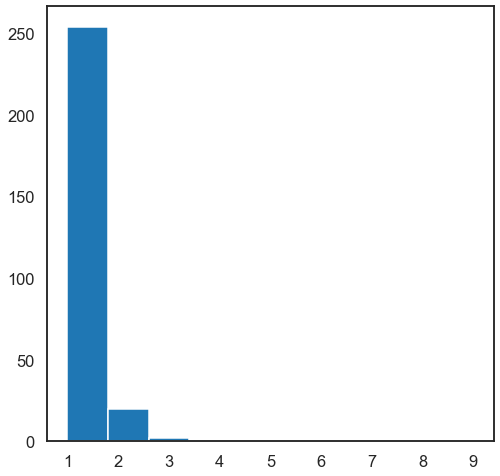

In [556]:
rolesPerComponent(Gt)

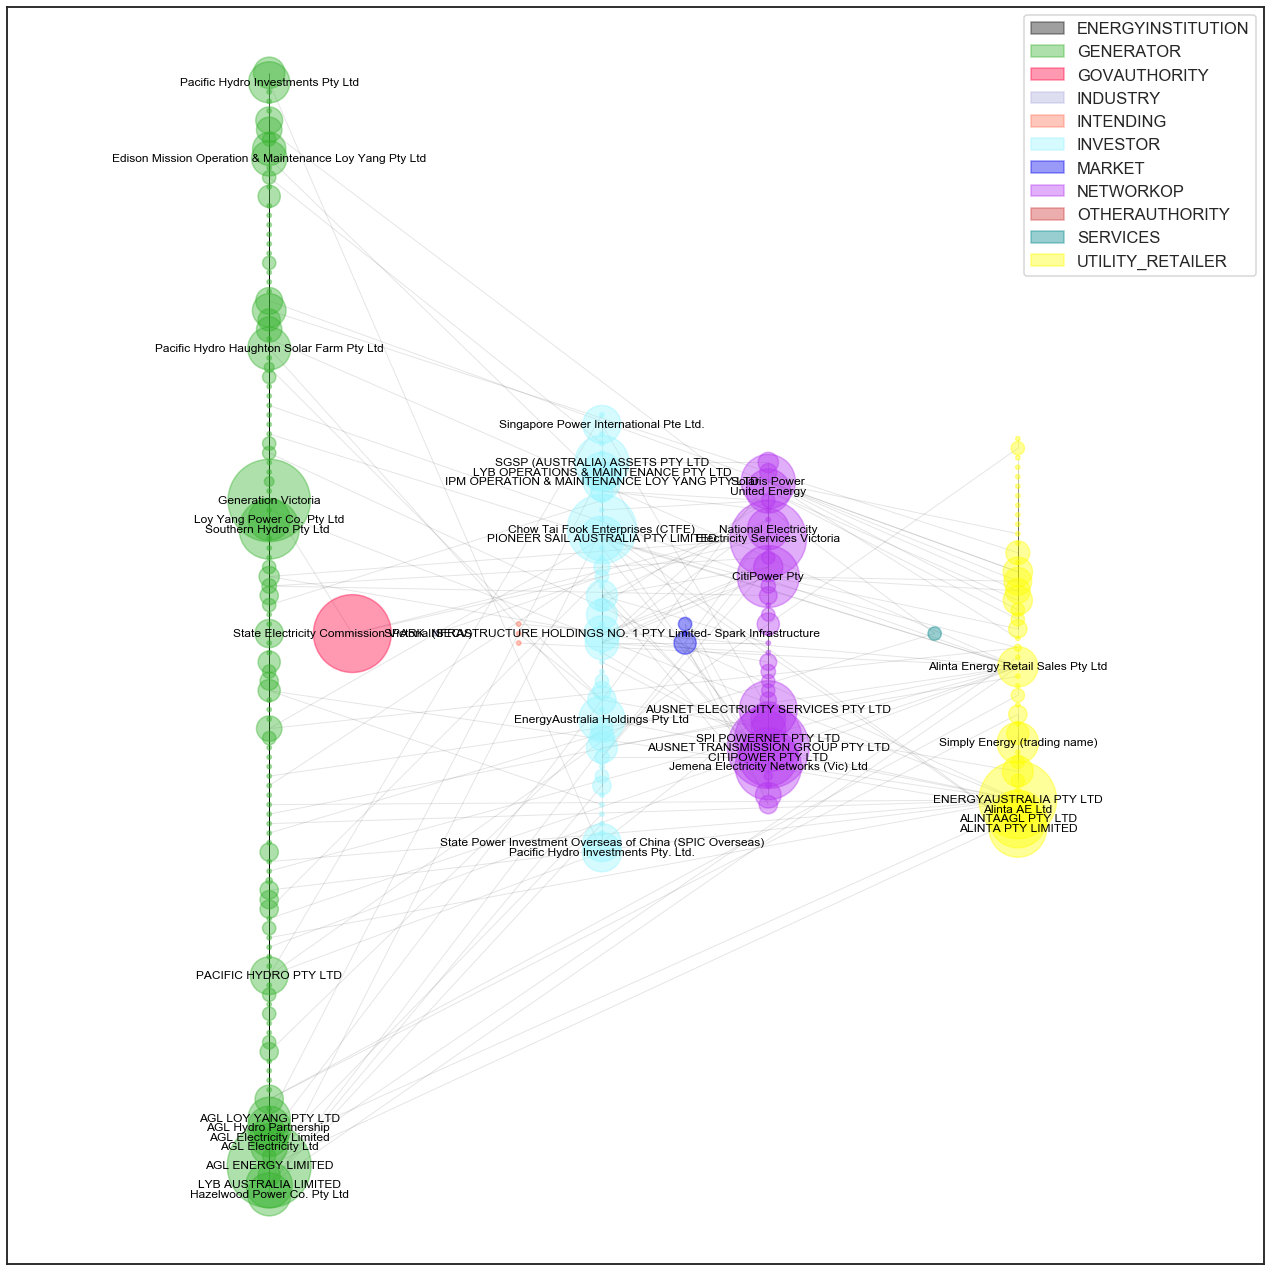

In [557]:

fig = plt.figure(figsize=(18, 18))

conn_comps = sorted(nx.connected_components(Gt), key=len, reverse=True)
nodes_subgraph = {n for n in conn_comps[0]}
Gt = G.subgraph(nodes_subgraph) #conn_comps[0] the grat clique

# Betweenness centrality
bet_cen = nx.betweenness_centrality(Gt)
node_size_cen = [20 + v * 20000 for v in bet_cen.values()]
node_size_deg = [v * 20 for n,v in Gt.degree()]
node_size = [ c+d for c,d in zip(node_size_cen,node_size_deg)]
#node_size_dict = {k:v * 20000 for k,v in bet_cen.items()}
#sorted_betweenness = sorted(bet_cen.items(), key=itemgetter(1), reverse=True)

labels = {}
for n in Gt.nodes():
    if bet_cen[n] > 0.06:
        labels[n] = G.nodes[n]['name']
        
colors = [role2color(Gt.nodes[n]['role']) for n in Gt.nodes]
pos = nx.spring_layout(Gcc, k=0.04, seed=10396953)
pos = nx.multipartite_layout(Gt, subset_key='rolenum',scale=1)
#pos = nx.planar_layout(Gt)

#nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20, node_color=colors,alpha=1)
nx.draw_networkx_nodes(Gt, pos, node_size=node_size_cen, node_color=colors,alpha=0.4)
nx.draw_networkx_labels(Gt,pos,labels,font_size=12,font_color='black')
nx.draw_networkx_edges(Gt, pos, alpha=0.1)
#ax0.set_title("Organisations in the History of Electricity Sector")
#ax0.set_axis_off()

energyInst = mpatches.Patch(color=role2color('ENERGYINSTITUTION'), label='ENERGYINSTITUTION', alpha =0.4)
generator = mpatches.Patch(color=role2color('GENERATOR'), label='GENERATOR', alpha =0.4)
govAuthority = mpatches.Patch(color=role2color('GOVAUTHORITY'), label='GOVAUTHORITY', alpha =0.4)
industry = mpatches.Patch(color=role2color('INDUSTRY'), label='INDUSTRY', alpha =0.4)
intending = mpatches.Patch(color=role2color('INTENDING'), label='INTENDING', alpha =0.4)
investor = mpatches.Patch(color=role2color('INVESTOR'), label='INVESTOR', alpha =0.4)
market = mpatches.Patch(color=role2color('MARKET'), label='MARKET', alpha =0.4)
networkOp = mpatches.Patch(color=role2color('NETWORKOP'), label='NETWORKOP', alpha =0.4)
otherAuth = mpatches.Patch(color=role2color('OTHERAUTHORITY'), label='OTHERAUTHORITY', alpha =0.4)
services = mpatches.Patch(color=role2color('SERVICES'), label='SERVICES', alpha =0.4)
utilityRetailer = mpatches.Patch(color=role2color('UTILITY_RETAILER'), label='UTILITY_RETAILER', alpha =0.4)

plt.legend(handles=[energyInst, generator, govAuthority, industry, intending, investor, market, networkOp, otherAuth, services, utilityRetailer])

fig.tight_layout()
plt.show()

### Filtered cluster example

In [658]:
graph_date = date(2015, 1, 1)

selected_nodes = [(n,v) for n,v in G.nodes(data=True) if 
                  dparser.parse(v['end_date'],fuzzy=True).date()+relativedelta(years=+1) >= graph_date] 
    
#Active Edges:
# edge_date occurs before t, i.e. edge_date <= t and
# src and dst end_date  + 1 month slack occurs after t, i.e. src_ed + 1month >=t and dst_ed + 1month >=t

selected_edges = [ (src,dst,data) for (src,dst,data) in G.edges(data=True) 
                  if 
                  dparser.parse(G.nodes(data=True)[src]['end_date'],fuzzy=True).date()+relativedelta(years=+1)>= graph_date and
                  dparser.parse(G.nodes(data=True)[dst]['end_date'],fuzzy=True).date()+relativedelta(years=+1)>= graph_date
                 ]

Gt = nx.Graph()
Gt.add_nodes_from(selected_nodes)
Gt.add_edges_from(selected_edges)
# metrics for direct participants in the market e.g. generators, retailers, etc.
filtered_nodes = [ (n,data)  for n,data in Gt.nodes(data=True) if data['role']!= 'GOVAUTHORITY' and 
                  data['role']!= 'ENERGYINSTITUTION' and data['role']!= 'MARKET' and 
                  data['role']!= 'OTHERAUTHORITY'] 

filtered_nodes_ids = [ n for n,data in filtered_nodes ] 

selected_edges = [ (src,dst,data) for (src,dst,data) in G.edges(data=True) 
                  if src in filtered_nodes_ids and dst in filtered_nodes_ids
                 ]

Gfiltered = nx.Graph()
Gfiltered.add_nodes_from(filtered_nodes)
Gfiltered.add_edges_from(selected_edges)


8739


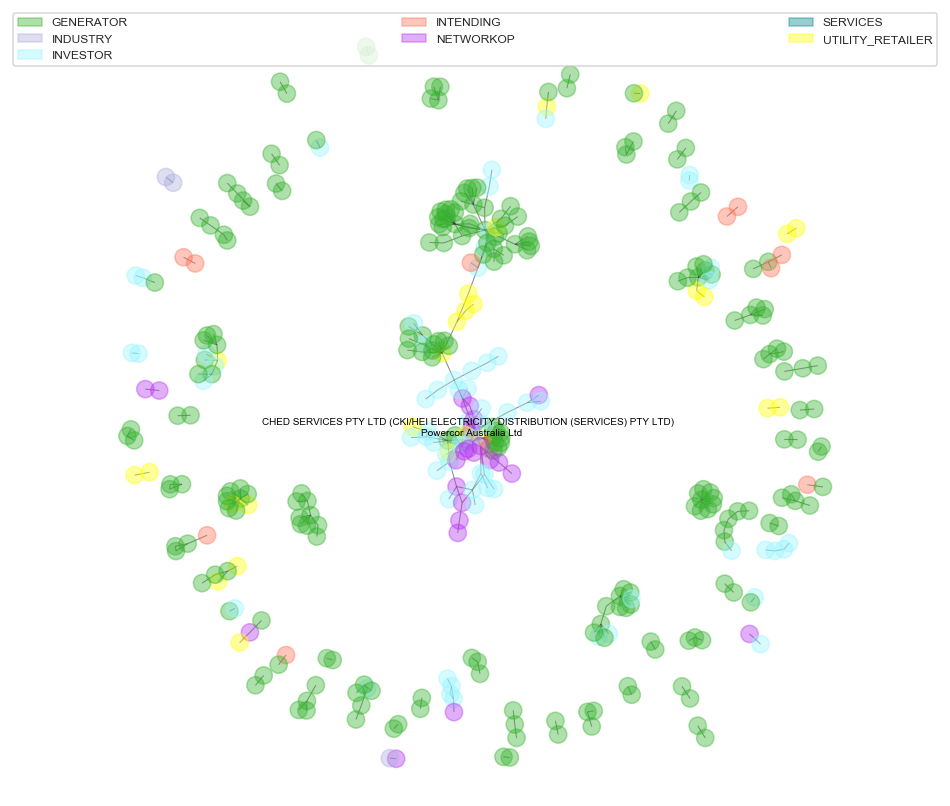

In [659]:
fig = plt.figure(figsize=(13, 11))

conn_comps = sorted(nx.connected_components(Gfiltered), key=len, reverse=True)
nodes_subgraph = {n for cc in conn_comps if len(cc) > 1 for n in cc}

Gs = Gfiltered.subgraph(nodes_subgraph)
colors = [role2color(Gs.nodes[n]['role']) for n in Gs.nodes]

seed = int(random.random()*100000)
print(seed)

pos = nx.spring_layout(Gs, k=0.05, seed=seed)
#pos = nx.nx.multipartite_layout(Gs, subset_key='rolenum')
#pos = nx.kamada_kawai_layout(Gs, scale=0.1)

#pos = nx.fruchterman_reingold_layout(Gs, k=0.01, seed=99503)
#10396967, 83581, 5895, k=0.01, seed=99503
nx.draw(Gs,pos,node_color=colors, alpha=0.4)
# draw path
# path = nx.shortest_path(Gs,source=209, target=931)
# path_edges = zip(path,path[1:])
# path_edges = set(path_edges)

labels = {}
for o in Gs.nodes():
    if o in path:
        labels[o] = Gs.nodes[o]['name']
        
nx.draw_networkx_labels(Gs,pos,labels,font_size=10,font_color='black')
#nx.draw_networkx_nodes(Gs, pos, node_size=node_size_cen, node_color=colors,alpha=0.6)
nx.draw_networkx_edges(Gs, pos, alpha=0.1)

#nx.draw_networkx_nodes(Gs, pos, nodelist=path, node_color='r',alpha=0.4)
#nx.draw_networkx_edges(Gs, pos, edgelist=path_edges, edge_color='r',width=5, alpha=0.5)
#pos = nx.multipartite_layout(Gs, subset_key='rolenum')
plt.legend(handles=[generator, industry, investor, intending, networkOp, services, utilityRetailer],
          loc='upper right', prop={'size': 12},ncol = 3, mode="expand")

plt.axis('equal')
#43179
#fig.tight_layout()
plt.show()

In [660]:
    num_nodes = len(Gs.nodes())
    largest_cc = len(max(conn_comps, key=len))

    ratioCcsNodes = (largest_cc/num_nodes)*100
    
    print("Percentage nodes in largest CC as a function of total number of nodes belonging to cc >1: ", ratioCcsNodes)
    print ("From a largest cc of: ", largest_cc, "and a total number of nodes of: ", num_nodes)


Percentage nodes in largest CC as a function of total number of nodes belonging to cc >1:  22.371967654986523
From a largest cc of:  83 and a total number of nodes of:  371


In [ ]:
# # set the figure size
# plt.figure(figsize=(14, 14))

# # from raw value to percentage
# role_bars = Gs.nodes('role')['role'].sum().reset_index()
# smoker = tips[tips.smoker=='Yes'].groupby('day')['total_bill'].sum().reset_index()
# smoker['total_bill'] = [i / j * 100 for i,j in zip(smoker['total_bill'], total['total_bill'])]
# total['total_bill'] = [i / j * 100 for i,j in zip(total['total_bill'], total['total_bill'])]

# # bar chart 1 -> top bars (group of 'smoker=No')
# bar1 = sns.barplot(x="day",  y="total_bill", data=total, color='darkblue')

# # bar chart 2 -> bottom bars (group of 'smoker=Yes')
# bar2 = sns.barplot(x="day", y="total_bill", data=smoker, color='lightblue')

# # add legend
# top_bar = mpatches.Patch(color='darkblue', label='smoker = No')
# bottom_bar = mpatches.Patch(color='lightblue', label='smoker = Yes')
# plt.legend(handles=[top_bar, bottom_bar])

# # show the graph
# plt.show()

## Business structure

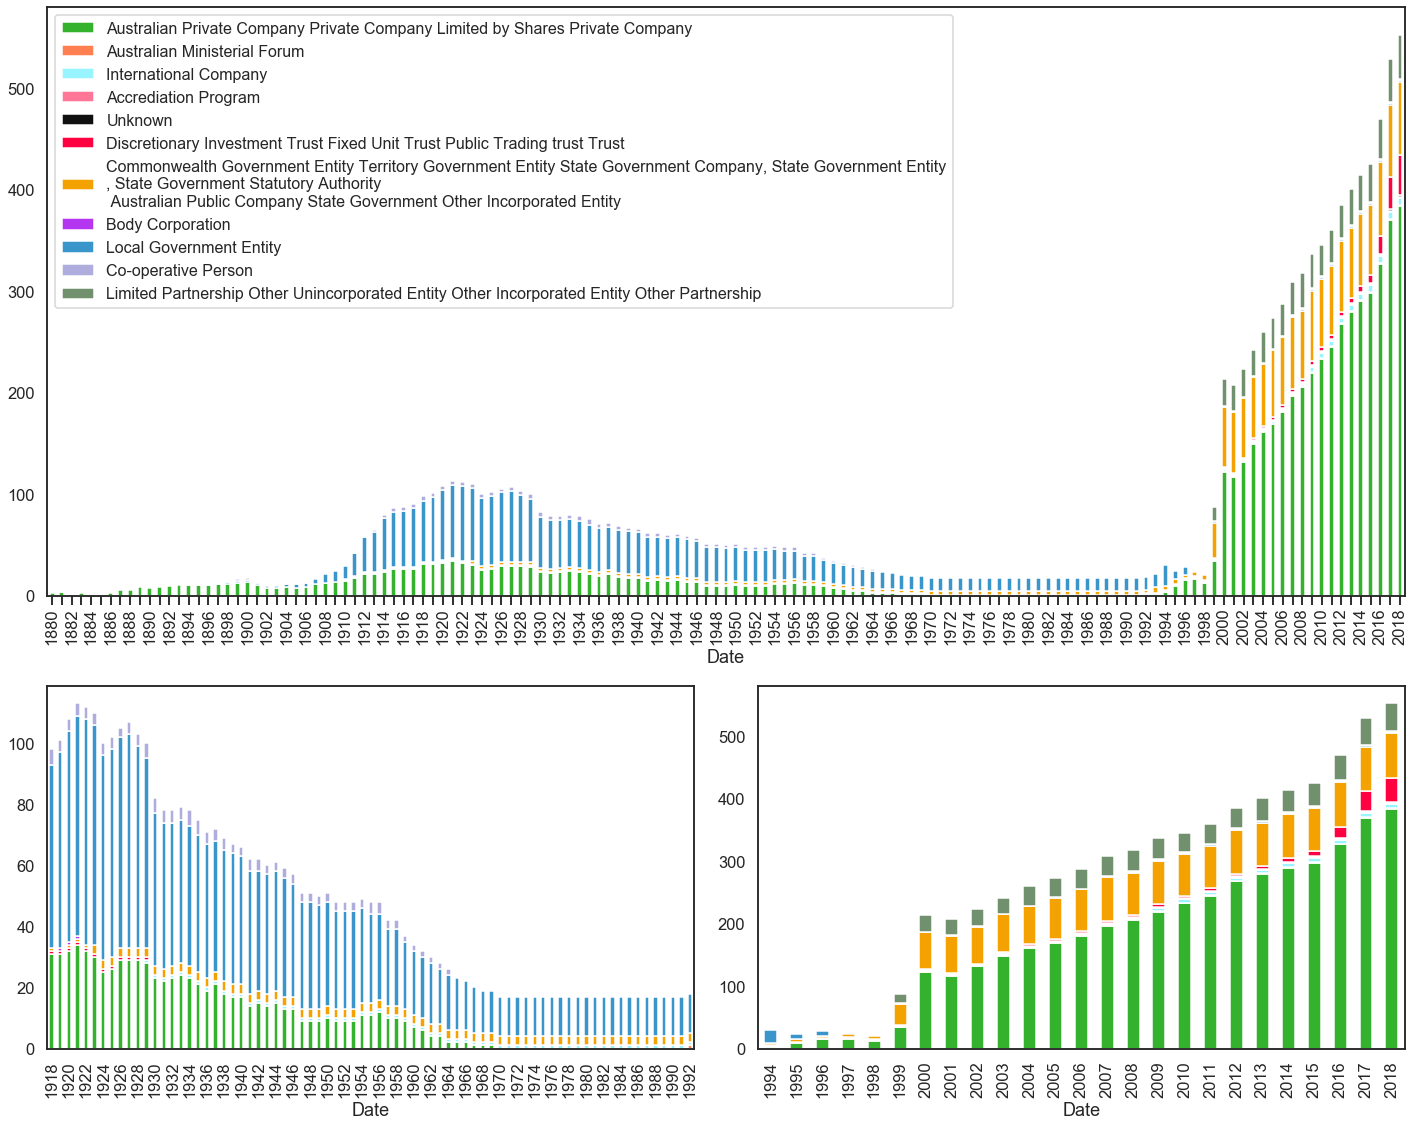

In [530]:
fig = plt.figure("Business Structures", figsize=(18, 18))

# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

#Aggregate businesses by colors
business_colors = set()
businesses_by_color = {}
for bs in business_structures:
    business_colors.add(bs2color(bs))
    if bs2color(bs) in businesses_by_color.keys():
        if bs == 'State Government Entity':
            businesses_by_color[bs2color(bs)]+= f', {bs}\n'
        elif bs == 'State Government Statutory Authority':
            businesses_by_color[bs2color(bs)]+= f', {bs}\n'
        else:
            businesses_by_color[bs2color(bs)]+= f' {bs}'
    else:
        businesses_by_color[bs2color(bs)] = f'{bs}'

        
# Add figure with all years
ax0 = fig.add_subplot(axgrid[0:3, :])

dataset = {'Date': [ d.year for d in nodes_time_year.keys() ]}
colors = []
    
for cbs in business_colors:
    dataset[businesses_by_color[cbs]] = np.zeros(len(dataset['Date'])) 
    colors.append(cbs)
    
for bs in business_structures:
    dataset[businesses_by_color[bs2color(bs)]] += [ v for (d,r),v in nodes_time_year_bs.items() if r == bs]   

nodes_time_year_bs_df = pd.DataFrame(dataset)
nodes_time_year_bs_df = nodes_time_year_bs_df.set_index('Date')

nodes_time_year_bs_df.plot.bar(ax=ax0,stacked=True, figsize=(20,16), color=colors)

ax0.grid(False)

ax0.tick_params(bottom=True, labelbottom=True)

ax0.set_xticklabels([ x if int(x.get_text()) % 2 == 0 else '' for x in ax0.get_xticklabels()])

ax0.axvline(x=pd.Timestamp(r1EndLine),color='r')
ax0.axvline(x=pd.Timestamp(r2EndLine),color='g')
ax0 = plt.legend(prop={'size': 16})

#ax0Legend = plt.legend(bbox_to_anchor=(0,1.02), loc="lower left", mode ="expand")
#ax0Legend = plt.legend(bbox_to_anchor=(1,0), loc="upper left", bbox_transform=fig.transFigure, ncol=3)
#plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",mode="expand", borderaxespad=0, ncol=3)

# Add figure from 1918 to 1969

ax1 = fig.add_subplot(axgrid[3:, :2])


dataset = {'Date': [ d.year for d in nodes_time_year.keys() if d.year >= 1918 and d.year < 1993]}
colors = []
for cbs in business_colors:
    dataset[businesses_by_color[cbs]] = np.zeros(len(dataset['Date'])) 
    colors.append(cbs)
    
for bs in business_structures:
    dataset[businesses_by_color[bs2color(bs)]] += [ v for (d,r),v in nodes_time_year_bs.items() if r == bs and
                                                   d.year >= 1918 and d.year < 1993]    

nodes_time_year_bs_df = pd.DataFrame(dataset)
nodes_time_year_bs_df = nodes_time_year_bs_df.set_index('Date')

nodes_time_year_bs_df.plot.bar(ax=ax1,stacked=True, figsize=(20,16), color=colors)

ax1.set_xticklabels([ x if int(x.get_text()) % 2 == 0 else '' for x in ax1.get_xticklabels()])

ax1.get_legend().remove()
# Add figure from 1994 onwards

ax2 = fig.add_subplot(axgrid[3:, 2:])


dataset = {'Date': [ d.year for d in nodes_time_year.keys() if d.year >= 1994]}
colors = []
for cbs in business_colors:
    dataset[businesses_by_color[cbs]] = np.zeros(len(dataset['Date'])) 
    colors.append(cbs)
    
for bs in business_structures:
    dataset[businesses_by_color[bs2color(bs)]] += [ v for (d,r),v in nodes_time_year_bs.items() if r == bs and
                                                   d.year >= 1994]      
   

nodes_time_year_bs_df = pd.DataFrame(dataset)
nodes_time_year_bs_df = nodes_time_year_bs_df.set_index('Date')
b
nodes_time_year_bs_df.plot.bar(ax=ax2,stacked=True, figsize=(20,16), color=colors)

ax2.get_legend().remove()

fig.tight_layout()
plt.show()


## Region

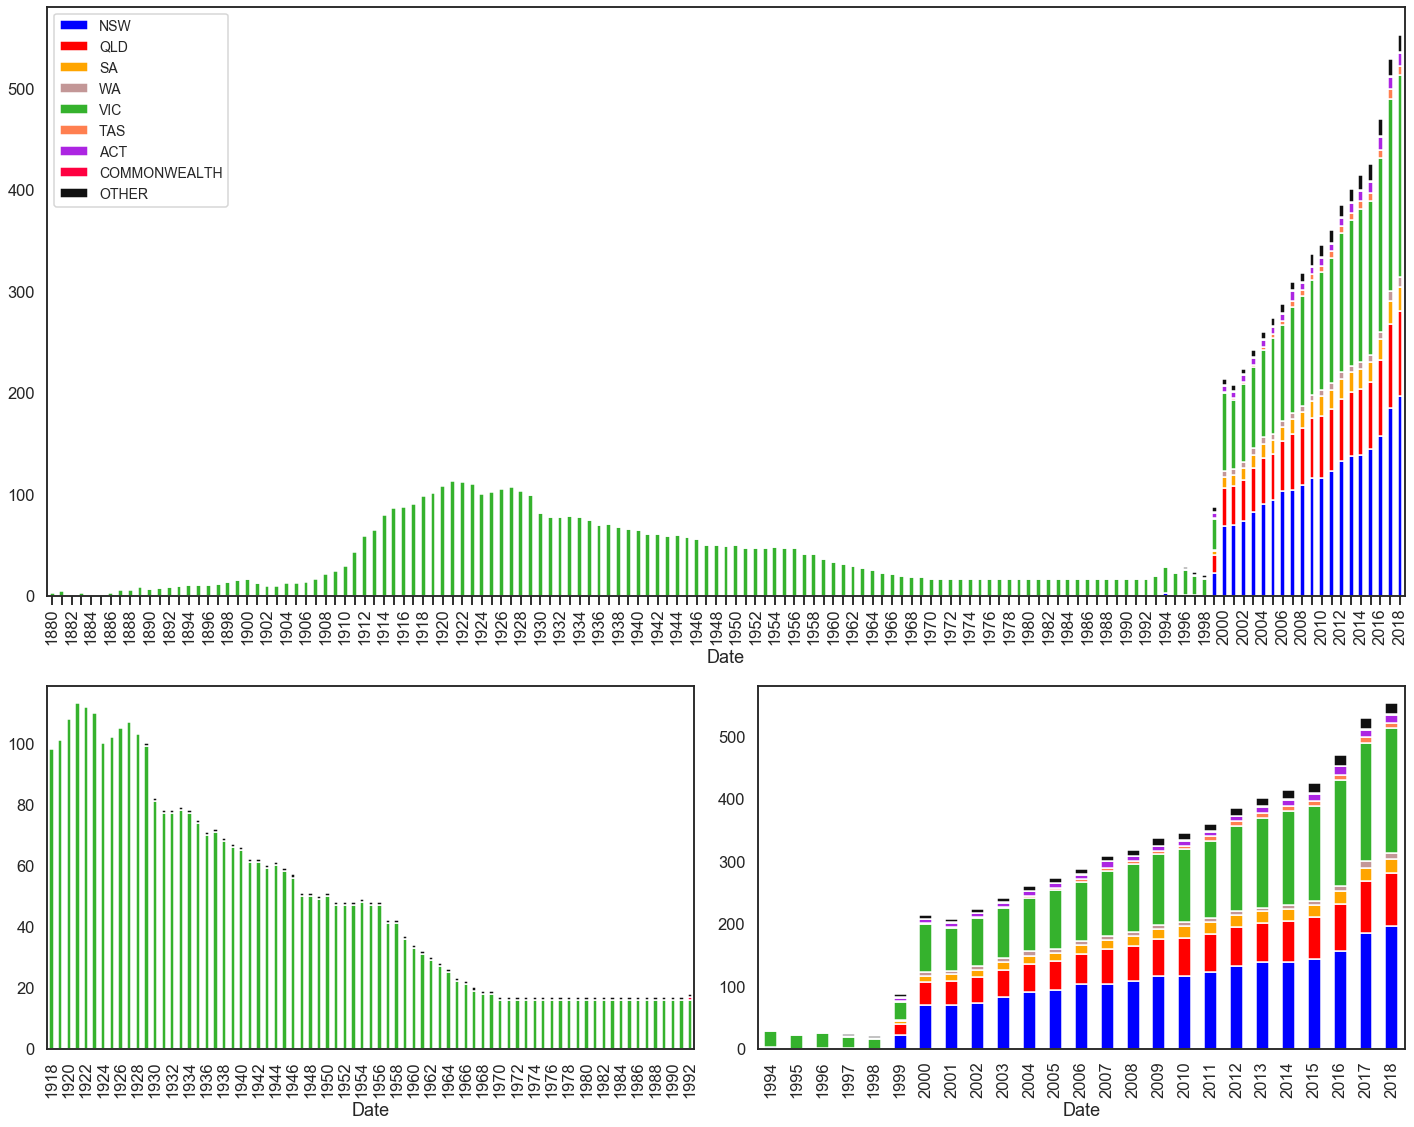

In [531]:
fig = plt.figure("Region", figsize=(18, 18))

# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)


# Add figure with all years
ax0 = fig.add_subplot(axgrid[0:3, :])

dataset = {'Date': [ d.year for d in nodes_time_year.keys() ]}
colors = []
for reg in regions:
    dataset[reg]= [ v for (d,r),v in nodes_time_year_region.items() if r == reg]
    colors.append(state2color(reg))
   

nodes_time_year_region_df = pd.DataFrame(dataset)
nodes_time_year_region_df = nodes_time_year_region_df.set_index('Date')

nodes_time_year_region_df.plot.bar(ax=ax0,stacked=True, figsize=(20,16), color=colors)

ax0.grid(False)

ax0.tick_params(bottom=True, labelbottom=True)

ax0.set_xticklabels([ x if int(x.get_text()) % 2 == 0 else '' for x in ax0.get_xticklabels()])
ax0 = plt.legend(prop={'size': 14})
#ax0.axvline(x=pd.Timestamp(r1EndLine),color='r')
#ax0.axvline(x=pd.Timestamp(r2EndLine),color='g')

# Add figure from 1918 to 1969

ax1 = fig.add_subplot(axgrid[3:, :2])


dataset = {'Date': [ d.year for d in nodes_time_year.keys() if d.year >= 1918 and d.year < 1993]}
colors = []
for reg in regions:
    dataset[reg]= [ v for (d,r),v in nodes_time_year_region.items() if r == reg and d.year >= 1918 and d.year < 1993]
    colors.append(state2color(reg))
   

nodes_time_year_region_df = pd.DataFrame(dataset)
nodes_time_year_region_df = nodes_time_year_region_df.set_index('Date')

nodes_time_year_region_df.plot.bar(ax=ax1,stacked=True, figsize=(20,16), color=colors)
ax1.set_xticklabels([ x if int(x.get_text()) % 2 == 0 else '' for x in ax1.get_xticklabels()])

ax1.get_legend().remove()
# Add figure from 1994 onwards

ax2 = fig.add_subplot(axgrid[3:, 2:])


dataset = {'Date': [ d.year for d in nodes_time_year.keys() if d.year >= 1994]}
colors = []
for reg in regions:
    dataset[reg]= [ v for (d,r),v in nodes_time_year_region.items() if r == reg and d.year >= 1994]
    colors.append(state2color(reg))
   

nodes_time_year_region_df = pd.DataFrame(dataset)
nodes_time_year_region_df = nodes_time_year_region_df.set_index('Date')

nodes_time_year_region_df.plot.bar(ax=ax2,stacked=True, figsize=(20,16), color=colors)

ax2.get_legend().remove()

fig.tight_layout()
plt.show()


## Relationship Plots

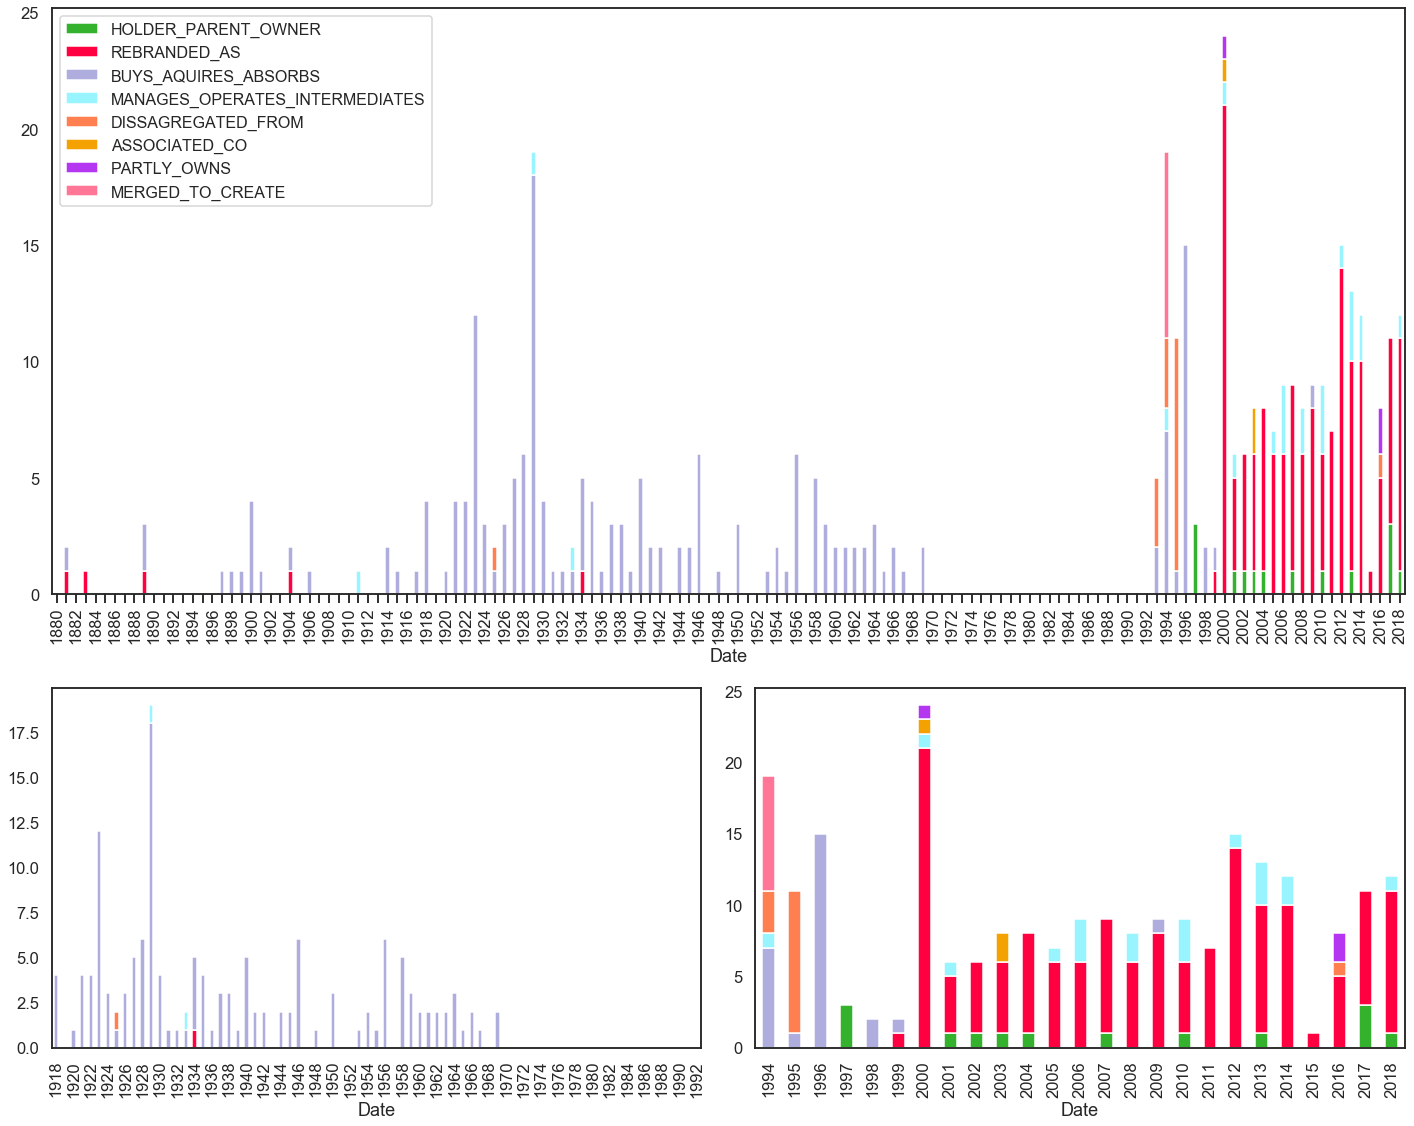

In [532]:

fig = plt.figure("Strategic Relationships", figsize=(18, 18))

# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)


# Add figure with all years
ax0 = fig.add_subplot(axgrid[0:3, :])

dataset = {'Date': [ d.year for d in nodes_time_year.keys() ]}
colors = []
for rel in relationships:
    dataset[relnum2relname(rel)]= [ v for (d,r),v in edges_time_year_rel.items() if int(r) == rel]
    colors.append(relnum2color(relnum2relname(rel)))
   

edges_time_df = pd.DataFrame(dataset)
edges_time_df = edges_time_df.set_index('Date')

edges_time_df.plot.bar(ax=ax0,stacked=True, figsize=(20,16), color=colors)

ax0.grid(False)

ax0.tick_params(bottom=True, labelbottom=True)

ax0.set_xticklabels([ x if int(x.get_text()) % 2 == 0 else '' for x in ax0.get_xticklabels()])
ax0 = plt.legend(prop={'size': 16})
#ax0.axvline(x=pd.Timestamp(r1EndLine),color='r')
#ax0.axvline(x=pd.Timestamp(r2EndLine),color='g')

# Add figure from 1918 to 1969

ax1 = fig.add_subplot(axgrid[3:, :2])


dataset = {'Date': [ d.year for d in nodes_time_year.keys() if d.year >= 1918 and d.year < 1993]}
colors = []
for rel in relationships:
    dataset[relnum2relname(rel)]= [ v for (d,r),v in edges_time_year_rel.items() if int(r) == rel and d.year >= 1918 and d.year < 1993]
    colors.append(relnum2color(relnum2relname(rel)))
   

edges_time_df = pd.DataFrame(dataset)
edges_time_df = edges_time_df.set_index('Date')

edges_time_df.plot.bar(ax=ax1,stacked=True, figsize=(20,16), color=colors)
ax1.set_xticklabels([ x if int(x.get_text()) % 2 == 0 else '' for x in ax1.get_xticklabels()])

ax1.get_legend().remove()
# Add figure from 1994 onwards

ax2 = fig.add_subplot(axgrid[3:, 2:])


dataset = {'Date': [ d.year for d in nodes_time_year.keys() if d.year >= 1994]}
colors = []
for rel in relationships:
    dataset[relnum2relname(rel)]= [ v for (d,r),v in edges_time_year_rel.items() if int(r) == rel and d.year >= 1994]
    colors.append(relnum2color(relnum2relname(rel)))
   

edges_time_df = pd.DataFrame(dataset)
edges_time_df = edges_time_df.set_index('Date')

edges_time_df.plot.bar(ax=ax2,stacked=True, figsize=(20,16), color=colors)

ax2.get_legend().remove()

fig.tight_layout()
plt.show()


In [533]:
# plot average degree for 'active edges and nodes' each year 
from datetime import date, timedelta
import dateutil.parser as dparser
from dateutil.relativedelta import *

def mean(data):
    n = len(data)
    mean = 0.0

    if n < 1:
        return float('nan');
    else:
        return sum(data) / n


def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

mean_degree_time_year = {}
graph_time_year = {}
edges_time_year = {}
nodes_time_year = {}
ccs_time_year = {}
ccs_size_time_year = {}
ccs_largest_time_year = {}
btw_time_year = {}
trans_size_time_year = {}
nodes_time_year_role = {}
nodes_time_year_bs = {}
nodes_time_year_region = {}
edges_time_year_rel = {}
for single_date in pd.date_range(start='1/1/1880', end='1/9/2019', freq='Y').values:
    sd = single_date.astype('M8[D]').astype('O')
    
    #Active nodes:
    # start_date occurs before t, i.e. sd <= t and
    # end_date occurs after t, i.e. ed >=t
    
    selected_nodes = [n for n,v in G.nodes(data=True) if dparser.parse(v['start_date'],fuzzy=True).date() <= sd and 
                      dparser.parse(v['end_date'],fuzzy=True).date() >= sd  ] 
    
    #Active Edges:
    # edge_date occurs before t, i.e. edge_date <= t and
    # src and dst end_date  + 1 month slack occurs after t, i.e. src_ed + 1month >=t and dst_ed + 1month >=t
    
    selected_edges = [ (src,dst,data) for (src,dst,data) in G.edges(data=True) 
                      if dparser.parse(data['edge_date'],fuzzy=True).date() <= sd and 
                      dparser.parse(G.nodes(data=True)[src]['end_date'],fuzzy=True).date()+relativedelta(years=+1)>= sd and
                      dparser.parse(G.nodes(data=True)[dst]['end_date'],fuzzy=True).date()+relativedelta(years=+1)>= sd
                     ]
         
    H = nx.Graph()
    H.add_nodes_from(selected_nodes)
    H.add_edges_from(selected_edges)
    
    graph_time_year[sd] = H
    mean_degree_time_year[sd] = mean([d for n, d in H.degree()])
    edges_time_year[sd] = len(H.edges())
    nodes_time_year[sd] = len(H.nodes())
    
    for role in roles:
        nodes_time_year_role[(sd,role)] = len([ r for r in H.nodes() if G.nodes[r]['role'] == role])
    
    for bs in business_structures:
        nodes_time_year_role[(sd,bs)] = len([ r for r in H.nodes() if G.nodes[r]['business'] == bs])
        
    for reg in regions:
        nodes_time_year_role[(sd,bs)] = len([ r for r in H.nodes() if G.nodes[r]['region'] == bs])
        
    ccs_time_year[sd] = list(nx.connected_components(H))
    ccs_size_time_year[sd] = len([ cc for cc in ccs_time_year[sd] if len(cc)>1])
    ccs_largest_time_year[sd] = len(max(ccs_time_year[sd], key=len))
    trans_size_time_year[sd] = nx.transitivity(H)
    bet_cen = nx.betweenness_centrality(H)
    sorted_betweenness = sorted(bet_cen.items(), key=itemgetter(1), reverse=True)
    btw_time_year[sd] = sorted_betweenness[:10]



    #print(single_date, len(selected_nodes),mean_degree_time[sd] )

In [534]:
largest_component = max(conn_comps_greater_1, key=len)
print(len(largest_component))
subgraph = G.subgraph(largest_component)
diameter = nx.diameter(subgraph)
print("Network diameter of largest component:", diameter)


424
Network diameter of largest component: 24


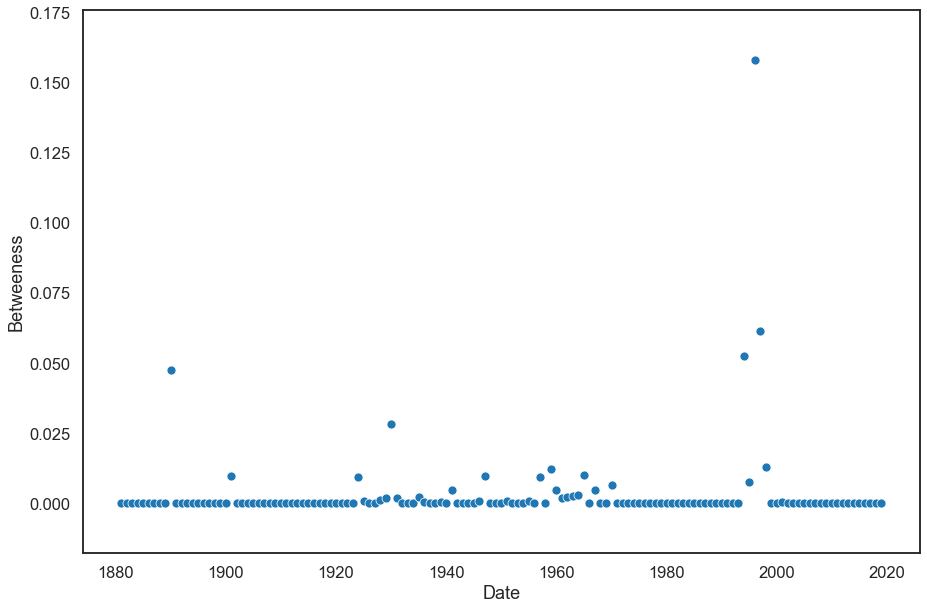

In [535]:
fig = plt.figure(figsize=(15,10))

btw_time_df = pd.DataFrame({'Date': list(btw_time_year.keys()),'Betweeness': [ max(v, key=itemgetter(1))[1] for v in btw_time_year.values()]})
btw_time_df.set_index(['Date'],inplace=True)
sns.scatterplot(data = btw_time_df, x='Date', y = 'Betweeness')


In [536]:
btw_time_year_ccs = {}
for sd,H in graph_time_year.items():
    Hlow = H.copy()
    #remove nodes with no edges
    low_degree = [n for n, d in Hlow.degree() if d < 1]
    Hlow.remove_nodes_from(low_degree)
    bet_cen = nx.betweenness_centrality(Hlow)
    sorted_betweenness = sorted(bet_cen.items(), key=itemgetter(1), reverse=True)
    btw_time_year_ccs[sd] = sorted_betweenness[:10]

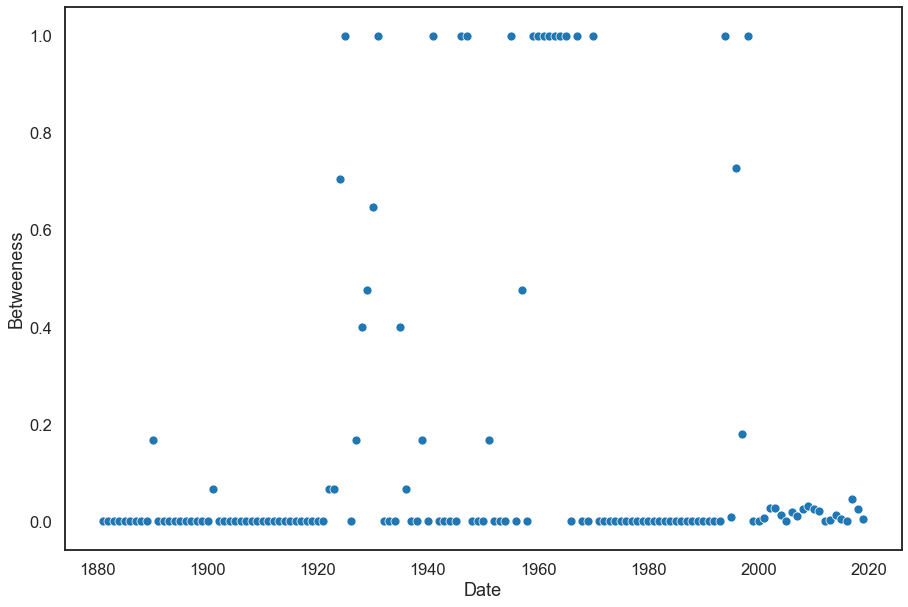

In [537]:
fig = plt.figure(figsize=(15,10))
max_btw = [] 
for vs in btw_time_year_ccs.values():
    max_v = 0
    for _,v in vs:
        if v > max_v: max_v = v
    max_btw.append(max_v)
    
btw_time_df = pd.DataFrame({'Date': list(btw_time_year_ccs.keys()),'Betweeness': max_btw})
btw_time_df.set_index(['Date'],inplace=True)
sns.scatterplot(data = btw_time_df, x='Date', y = 'Betweeness')


# Regime Stats

In [669]:
# plot average degree for 'active edges and nodes' each year 
def mean(data):
    n = len(data)
    mean = 0.0

    if n < 1:
        return float('nan');
    else:
        return sum(data) / n


def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

mean_degree_time_year = {}
graph_time_year = {}
edges_time_year = {}
nodes_time_year = {}
ccs_time_year = {}
ccs_size_time_year = {}
ccs_largest_time_year = {}
communities_time_year = {}
communities_size_time_year = {}
btw_time_year = {}
trans_size_time_year = {}
nodes_time_year_role = {}
nodes_time_year_bs = {}
nodes_time_year_region = {}
edges_time_year_rel = {}
ratioCcsNodes = {}
# communities during regimes,: emerging: 1879, 1, 1 to 1919, 12, 31; public: 1920, 1, 1 to 1994, 12, 31; private until 2019
for name,start,end in [('Emerging','1/1/1880','31/12/1919'),('Public','1/1/1920','31/12/1994'),('Private','1/1/1995','31/12/2020')]:
    startd = dparser.parse(start,fuzzy=True).date()
    endd =  dparser.parse(end,fuzzy=True).date()
    middled = name
    #Active nodes:
    # start_date occurs before t, i.e. sd <= t and
    # end_date occurs after t, i.e. ed >=t

    
    selected_nodes = [(n,v) for n,v in G.nodes(data=True) if dparser.parse(v['start_date'],fuzzy=True).date() >= startd 
                       and dparser.parse(v['start_date'],fuzzy=True).date()  <= endd  
                     ] 
    
    
    #Active Edges:
    # edge_date occurs before t, i.e. edge_date <= t and
    # src and dst end_date  + 1 month slack occurs after t, i.e. src_ed + 1month >=t and dst_ed + 1month >=t
    
    selected_edges = [ (src,dst,data) for (src,dst,data) in G.edges(data=True) 
                      if dparser.parse(G.nodes(data=True)[src]['end_date'],fuzzy=True).date() >= startd and
                      dparser.parse(G.nodes(data=True)[dst]['start_date'],fuzzy=True).date() >= startd and
                      dparser.parse(G.nodes(data=True)[src]['start_date'],fuzzy=True).date() <= endd and
                      dparser.parse(G.nodes(data=True)[dst]['start_date'],fuzzy=True).date() <= endd
                     ]
    
   
    H = nx.Graph()
    H.add_nodes_from(selected_nodes)
    H.add_edges_from(selected_edges)
    
    graph_time_year[middled] = H
    mean_degree_time_year[middled] = mean([d for n, d in H.degree()])
    edges_time_year[middled] = len(H.edges())
    nodes_time_year[middled] = len(H.nodes())
    
    for role in roles:
        nodes_time_year_role[(middled,role)] = len([ r for r in H.nodes() if G.nodes[r]['role'] == role])
    
    for bs in business_structures:
        nodes_time_year_bs[(middled,bs)] = len([ r for r in H.nodes() if G.nodes[r]['business'] == bs])
        
    for reg in regions:
        nodes_time_year_region[(middled,reg)] = len([ r for r in H.nodes() if G.nodes[r]['region'] == reg])
     
    for rel in relationships:
        edges_time_year_rel[(middled,rel)] = len([ (src,dst,data) for src,dst,data in H.edges(data=True) if data['relationship'] == rel])
        
    ccs_time_year[middled] = list(nx.connected_components(H))
    ccs_size_time_year[middled] = len([ cc for cc in ccs_time_year[middled] if len(cc)>1])
    ccs_largest_time_year[middled] = len(max(ccs_time_year[middled], key=len))
    if len(H.edges()) > 0:
        communities_time_year[middled] = list(community.greedy_modularity_communities(H))
        communities_size_time_year[middled] = len([ cc for cc in communities_time_year[middled] if len(cc)>1])
    else:
        communities_time_year[middled] = 0
        communities_size_time_year[middled] = 0
        
    trans_size_time_year[middled] = nx.transitivity(H)
    bet_cen = nx.betweenness_centrality(H)
    sorted_betweenness = sorted(bet_cen.items(), key=itemgetter(1), reverse=True)
    btw_time_year[middled] = sorted_betweenness[:10]
    ratioCcsNodes[middled] = (ccs_largest_time_year[middled]/nodes_time_year[middled])*100


    #print(single_date, len(selected_nodes),mean_degree_time[sd] )

Text(0.5, 0, '')

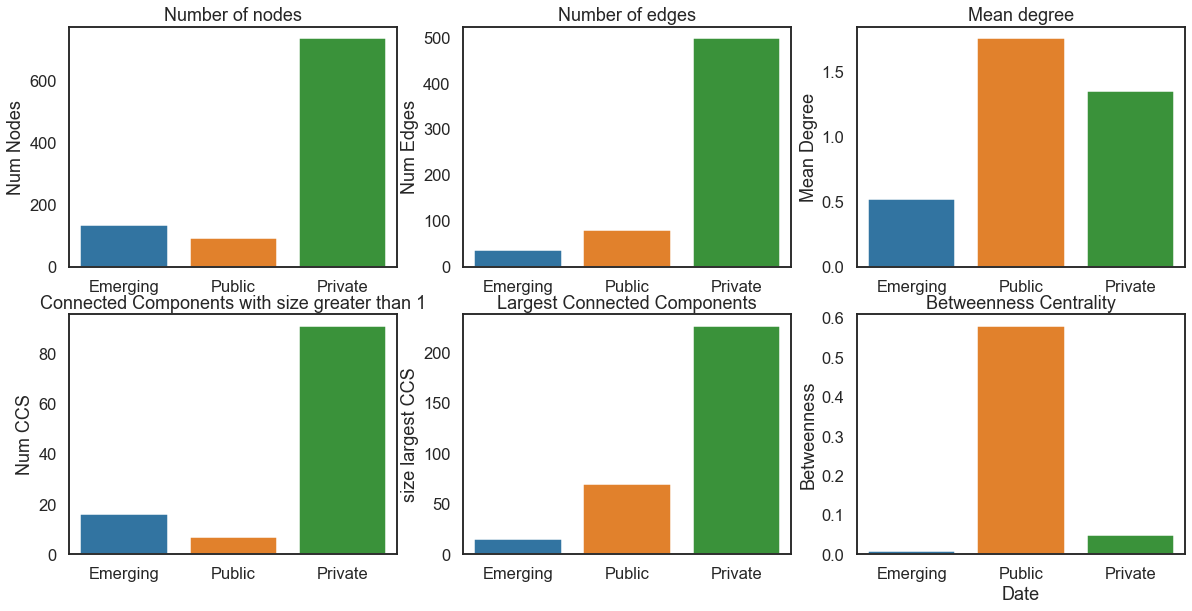

In [670]:
sns.set_context("talk")
fig = plt.figure(figsize=(20, 15))
#fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6, sharex=True)

nodes_time_year_df = pd.DataFrame({'Date': list(nodes_time_year.keys()),'Num Nodes': list(nodes_time_year.values())})
#nodes_time_year_df.set_index(['Date'],inplace=True)

edges_time_year_df = pd.DataFrame({'Date': list(edges_time_year.keys()),'Num Edges': list(edges_time_year.values())})
#edges_time_year_df.set_index(['Date'],inplace=True)

mean_degree_time_year_df = pd.DataFrame({'Date': list(mean_degree_time_year.keys()),'Mean Degree': list(mean_degree_time_year.values())})
#mean_degree_time_year_df.set_index(['Date'],inplace=True)

ccs_size_time_year_df = pd.DataFrame({'Date': list(ccs_size_time_year.keys()),'Num CCS': list(ccs_size_time_year.values())})
#ccs_size_time_year_df.set_index(['Date'],inplace=True)

communities_size_time_year_df = pd.DataFrame({'Date': list(communities_size_time_year.keys()),'Num Communities': list(communities_size_time_year.values())})
#communities_size_time_year_df.set_index(['Date'],inplace=True)

ccs_largest_time_year_df = pd.DataFrame({'Date': list(ccs_largest_time_year.keys()),'size largest CCS': list(ccs_largest_time_year.values())})
#ccs_largest_time_year_df.set_index(['Date'],inplace=True)

trans_size_time_year_df = pd.DataFrame({'Date': list(trans_size_time_year.keys()),'Transitivity': list(trans_size_time_year.values())})
#trans_size_time_year_df.set_index(['Date'],inplace=True)

# btw_time_year_df = pd.DataFrame({'Date': list(btw_time_year.keys()),'Betweenness Centrality': list(btw_time_year.values())})
# btw_time_year_df.set_index(['Date'],inplace=True)

btw_time_df = pd.DataFrame({'Date': list(btw_time_year.keys()),'Betweenness': [ max(v, key=itemgetter(1))[1] for v in btw_time_year.values()]})
#btw_time_df.set_index(['Date'],inplace=True)

ratioNodesCcs_time_year_df = pd.DataFrame({'Date': list(ratioCcsNodes.keys()), 'Percentage of Nodes in Largest CC': list(ratioCcsNodes.values())})

#mean_degree_time_df.plot(figsize=(18, 18))
#plt.xticks(rotation=90)
r1EndLine = '1919-1-1'
r2EndLine = '1994-1-1'
# plt.axvline(pd.Timestamp(r1EndLine),color='r')
# plt.axvline(pd.Timestamp(r2EndLine),color='g')

#number of nodes

ax1 = plt.subplot(331)
plt.title('Number of nodes')
sns.barplot(data = nodes_time_year_df, x='Date', y = 'Num Nodes')
# plt.axvline(pd.Timestamp(r1EndLine),color='r')
# plt.axvline(pd.Timestamp(r2EndLine),color='g')
ax1.set_xlabel('')
# number of edges

ax2 = plt.subplot(332)
plt.title('Number of edges')
sns.barplot(data = edges_time_year_df, x='Date', y = 'Num Edges')
# plt.axvline(pd.Timestamp(r1EndLine),color='r')
# plt.axvline(pd.Timestamp(r2EndLine),color='g')
ax2.set_xlabel('')

#nodes_time_df.plot(figsize=(18, 18))
#plt.xticks(rotation=90)

# mean degree

ax3 = plt.subplot(3,3,3, sharex=ax1)
plt.title('Mean degree')
sns.barplot(data = mean_degree_time_year_df, x='Date', y = 'Mean Degree')
# plt.axvline(pd.Timestamp(r1EndLine),color='r')
# plt.axvline(pd.Timestamp(r2EndLine),color='g')
ax3.set_xlabel('')

# connected components

ax4 = plt.subplot(3,3,4, sharex=ax2)
plt.title('Connected Components with size greater than 1')
sns.barplot(data = ccs_size_time_year_df, x='Date', y = 'Num CCS')
# plt.axvline(pd.Timestamp(r1EndLine),color='r')
# plt.axvline(pd.Timestamp(r2EndLine),color='g')
ax4.set_xlabel('')

#largest connected component measure over time
ax5 = plt.subplot(3,3,5)
plt.title('Largest Connected Components')
sns.barplot(data = ccs_largest_time_year_df, x='Date', y = 'size largest CCS')
# plt.axvline(pd.Timestamp(r1EndLine),color='r')
# plt.axvline(pd.Timestamp(r2EndLine),color='g')
ax6.set_xlabel('')

ax6 = plt.subplot(3,3,6)
plt.title('Betweenness Centrality')
# plt.axvline(pd.Timestamp(r1EndLine),color='r')
# plt.axvline(pd.Timestamp(r2EndLine),color='g')
# max_btw = [] 
# for vs in btw_time_year_ccs.values():
#     max_v = 0
#     for _,v in vs:
#         if v > max_v: max_v = v
#     max_btw.append(max_v)
   
#btw_time_df = pd.DataFrame({'Date': list(btw_time_year.keys()),'Max Betweeness': max_btw})
#btw_time_df.set_index(['Date'],inplace=True)
sns.barplot(data = btw_time_df, x='Date', y = 'Betweenness')
ax5.set_xlabel('')




% nodes in largest cc:         Date  Percentage of Nodes in Largest CC
0  Emerging                          11.111111
1    Public                          76.923077
2   Private                          30.623306
num of nodes:  {'Emerging': 135, 'Public': 91, 'Private': 738} largest_cc:  {'Emerging': 15, 'Public': 70, 'Private': 226}
num of strategic relationships {'Emerging': 35, 'Public': 80, 'Private': 498}
Degree per regime:  {'Emerging': 0.5185185185185185, 'Public': 1.7582417582417582, 'Private': 1.3495934959349594}
Connected components > 1:  {'Emerging': 16, 'Public': 7, 'Private': 91}
Betweenness centrality:         Date  Betweenness
0  Emerging     0.007182
1    Public     0.579276
2   Private     0.049335
Betweenness centrality:  {'Emerging': [(20, 0.00718213444057906), (23, 0.0054988216810683424), (29, 0.004039950622825721), (10, 0.0037032880709235777), (5, 0.0037032880709235777), (13, 0.0028055212658511953), (4, 0.0026933004152171476), (3, 0.0014588710582426215), (19, 0.0006

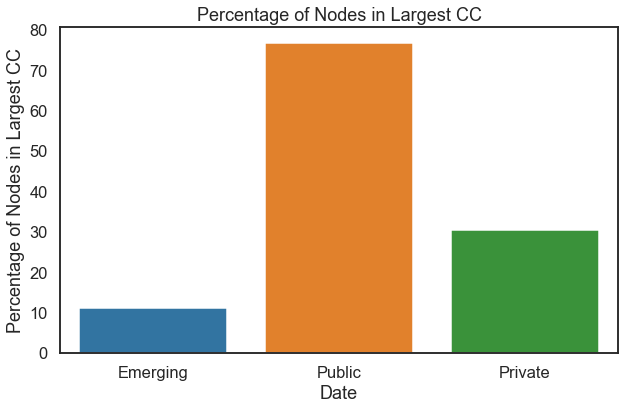

In [671]:
# percentage of nodes within the largest component in each regime
plt.figure(figsize=(10, 6))
plt.title('Percentage of Nodes in Largest CC')
sns.barplot(data = ratioNodesCcs_time_year_df, x='Date', y = 'Percentage of Nodes in Largest CC')
# plt.axvline(pd.Timestamp(r1EndLine),color='r')
# plt.axvline(pd.Timestamp(r2EndLine),color='g')
ax1.set_xlabel('')
print("% nodes in largest cc: ", ratioNodesCcs_time_year_df)
print("num of nodes: ", nodes_time_year, "largest_cc: ", ccs_largest_time_year)
print("num of strategic relationships", edges_time_year)
print("Degree per regime: ", mean_degree_time_year)
print("Connected components > 1: ", ccs_size_time_year)
print("Betweenness centrality: ", btw_time_df)
print("Betweenness centrality: ", btw_time_year)

In [ ]:
# # make stacked bar plot here where each regime is divided by role

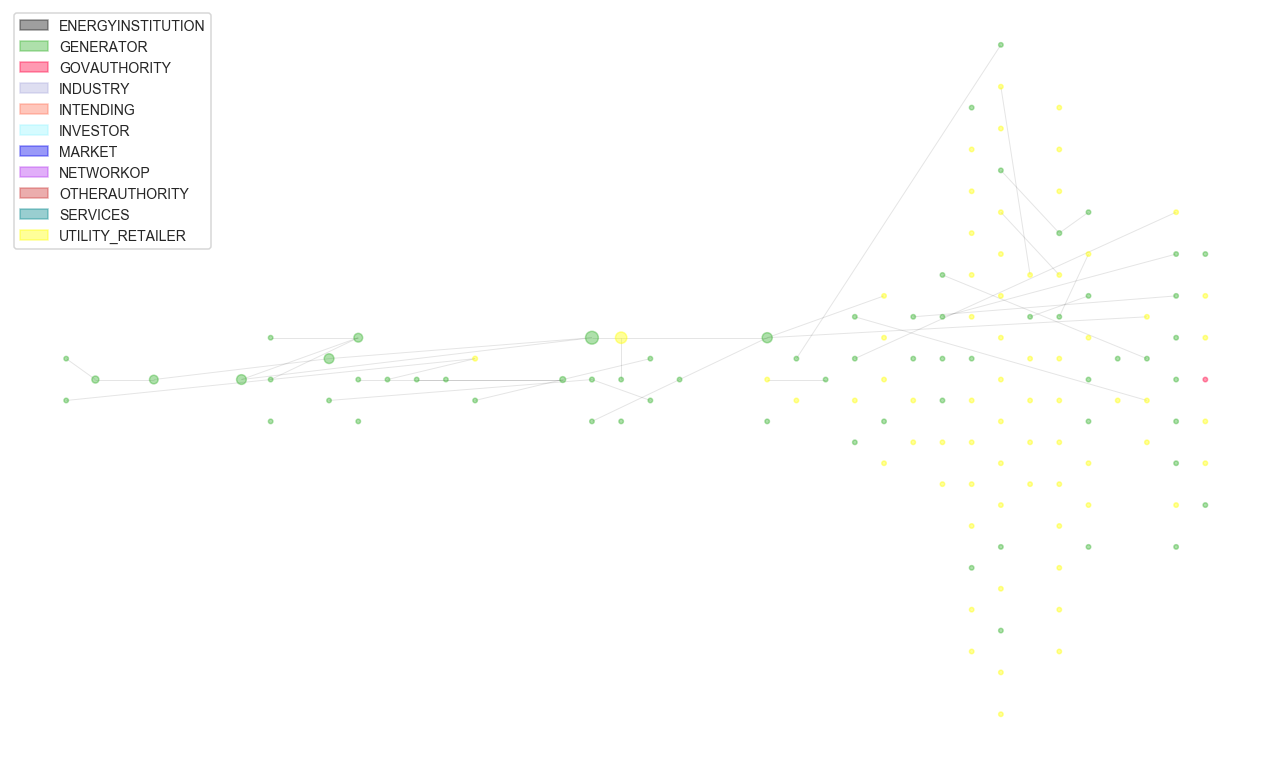

KeyError: 'role'

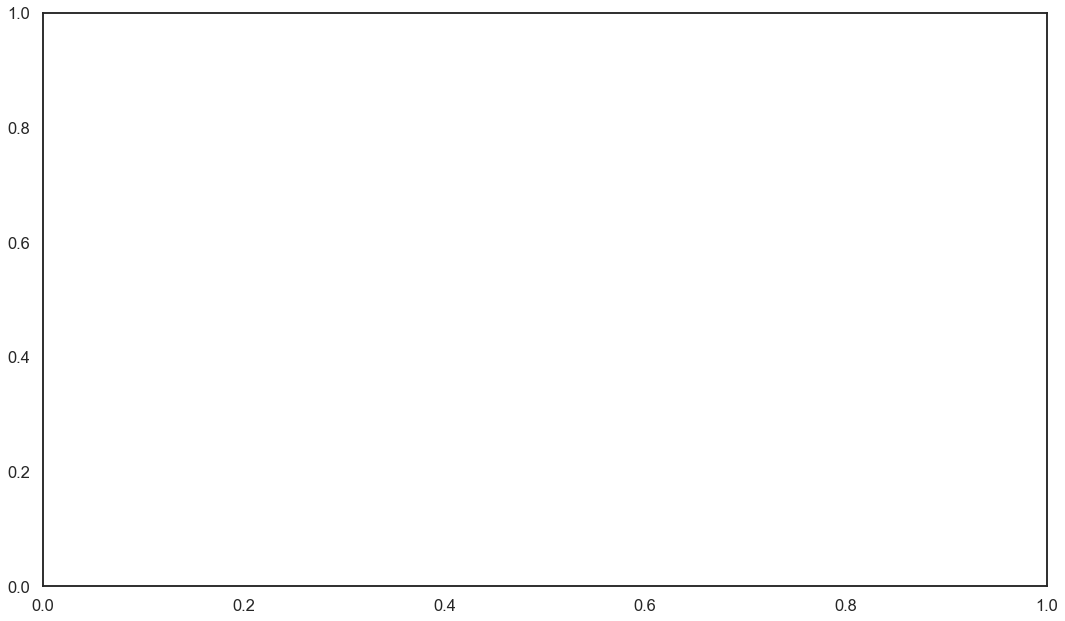

In [541]:
for name in ('Emerging','Public','Private'):
    GRegime = graph_time_year[name] 
    conn_comps = sorted(nx.connected_components(GRegime), key=len, reverse=True)
    conn_comps_greater_1 = [c for c in sorted(nx.connected_components(GRegime), key=len, reverse=True) if len(c) > 1]

    degree_sequence = sorted([d for n, d in GRegime.degree()], reverse=True)
    dmax = max(degree_sequence)

    fig = plt.figure("Degree of a random graph", figsize=(18, 18))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(5, 4)

    ax0 = fig.add_subplot(axgrid[0:3, :])

    nodes_subgraph = {n for cc in conn_comps for n in cc}
    Gcc = GRegime.subgraph(nodes_subgraph) #conn_comps[0] the grat clique

    # Betweenness centrality
    bet_cen = nx.betweenness_centrality(GRegime)
    node_size_cen = [20 + v * 20000 for v in bet_cen.values()]
    node_size_deg = [v * 20 for n,v in GRegime.degree()]
    node_size = [ c+d for c,d in zip(node_size_cen,node_size_deg)]
    #node_size_dict = {k:v * 20000 for k,v in bet_cen.items()}


    colors = [role2color(GRegime.nodes[n]['role']) for n in GRegime.nodes]
    #pos = nx.spring_layout(Gcc, k=0.05, seed=10396953)
    pos = nx.multipartite_layout(GRegime, subset_key='start_year')

    #nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20, node_color=colors,alpha=1)
    nx.draw_networkx_nodes(GRegime, pos, ax=ax0, node_size=node_size_cen, node_color=colors,alpha=0.4)
    nx.draw_networkx_edges(GRegime, pos, ax=ax0, alpha=0.1)
    #ax0.set_title("Organisations in the History of Electricity Sector")
    ax0.set_axis_off()

    energyInst = mpatches.Patch(color=role2color('ENERGYINSTITUTION'), label='ENERGYINSTITUTION', alpha =0.4)
    generator = mpatches.Patch(color=role2color('GENERATOR'), label='GENERATOR', alpha =0.4)
    govAuthority = mpatches.Patch(color=role2color('GOVAUTHORITY'), label='GOVAUTHORITY', alpha =0.4)
    industry = mpatches.Patch(color=role2color('INDUSTRY'), label='INDUSTRY', alpha =0.4)
    intending = mpatches.Patch(color=role2color('INTENDING'), label='INTENDING', alpha =0.4)
    investor = mpatches.Patch(color=role2color('INVESTOR'), label='INVESTOR', alpha =0.4)
    market = mpatches.Patch(color=role2color('MARKET'), label='MARKET', alpha =0.4)
    networkOp = mpatches.Patch(color=role2color('NETWORKOP'), label='NETWORKOP', alpha =0.4)
    otherAuth = mpatches.Patch(color=role2color('OTHERAUTHORITY'), label='OTHERAUTHORITY', alpha =0.4)
    services = mpatches.Patch(color=role2color('SERVICES'), label='SERVICES', alpha =0.4)
    utilityRetailer = mpatches.Patch(color=role2color('UTILITY_RETAILER'), label='UTILITY_RETAILER', alpha =0.4)

    ax0_legend = plt.legend(loc='upper left', 
                            handles=[energyInst, generator, govAuthority, industry, intending, investor, market, networkOp, otherAuth, services, utilityRetailer],
                          prop={'size': 14})


    # ax1 = fig.add_subplot(axgrid[3:, :2])
    # ax1.plot(degree_sequence, "b-", marker="o")
    # ax1.set_title("Degree Rank Plot")
    # ax1.set_ylabel("Degree")
    # ax1.set_xlabel("Rank")

    # ax2 = fig.add_subplot(axgrid[3:, 2:])
    # ax2.bar(*np.unique(degree_sequence, return_counts=True))
    # ax2.set_title("Degree histogram")
    # ax2.set_xlabel("Degree")
    # ax2.set_ylabel("# of Nodes")
    #ax0.tick_params(bottom=True, labelbottom=True)

    fig.tight_layout()
    plt.show()

In [ ]:
degreeRegime_dict = dict(GRegime.degree(GRegime.nodes()))

sorted_betweenness = sorted(bet_cen.items(), key=itemgetter(1), reverse=True)

print("Top 20 nodes by betweenness centrality removing nodes with degree 0:")
for b in sorted_betweenness[:20]:
    print(f"{G.nodes[b[0]]['start_year']} | {G.nodes[b[0]]['name']} | {G.nodes[b[0]]['role']} | ",
          f'betweeness: {b[1]:.3f} | Degree: {degreeRegime_dict[b[0]]}' )
    
# # Closeness centrality
# clo_cen = nx.closeness_centrality(G)
# # Eigenvector centrality
# eig_cen = nx.eigenvector_centrality(G)

# Power Law 

In [ ]:
degree_sequence = sorted([d for n, d in GRegime.degree() if d>0 and d <= 10 ], reverse=True) #if d>0 and d <= 10

In [ ]:
## 2 < k < sqr(n), to decide if it can be included for the scale-free test (this test if the network is to dense or to sparse)
mean_degree = np.mean(degree_sequence)
sqrt_nodes = np.sqrt(len(GRegime.nodes()))
print('Mean Degree: ',mean_degree)
print('Sqrt(num nodes)',sqrt_nodes )
print('is  2 <= mean degree <= srqt(nodes)? ', 2 <= mean_degree <= sqrt_nodes)
#k = mean_degree_time

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(*np.unique(degree_sequence, return_counts=True))
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Degree")
plt.title("Degree histogram (Log)")
#plt.ylabel("# of Nodes")
#ax0.tick_params(bottom=True, labelbottom=True)

In [ ]:
#source https://pypi.org/project/powerlaw/
import powerlaw # Power laws are probability distributions with the form:p(x)∝x−α
degree_sequence = [d for n, d in GRegime.degree() ]
fit = powerlaw.Fit(degree_sequence) 
print(f"alpha: {fit.power_law.alpha}")
print(f"xmin: {fit.power_law.xmin}")
R, p = fit.distribution_compare('power_law', 'lognormal')


In [ ]:
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
fig2 = fit.plot_pdf(color='b', linewidth=2)
pwlw = fit.power_law.plot_pdf(color='r', linestyle='--', ax=fig2)
lognorm = fit.lognormal.plot_pdf(ax=fig2, color='g', linestyle='dotted') #lognormal
expo = fit.stretched_exponential.plot_pdf(ax=fig2, color='y', linestyle='--') #stretched_exponential


#plt.legend()
#fig2.set_x

In [ ]:
R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print (R, p)

In [ ]:
plt.figure(figsize=(10, 6))
fit.distribution_compare('power_law', 'lognormal')
fig4 = fit.plot_ccdf(linewidth=3, color='black')
pwlw = fit.power_law.plot_ccdf(ax=fig4, color='r', linestyle='--') #powerlaw
lognorm = fit.lognormal.plot_ccdf(ax=fig4, color='g', linestyle='dotted') #lognormal
expo = fit.stretched_exponential.plot_ccdf(ax=fig4, color='b', linestyle='--') #stretched_exponential

#handels = ()
#fig4.legend(handels = )